# GPT2 part

In [2]:
!pip install sae-lens transformer-lens seaborn

In [1]:
import numpy as np
import torch
import plotly_express as px
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from huggingface_hub import hf_hub_download, notebook_login
import numpy as np
import torch
from transformer_lens import HookedTransformer

# Model Loading
from sae_lens import SAE
from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list

# Virtual Weight / Feature Statistics Functions
from sae_lens.analysis.feature_statistics import (
    get_all_stats_dfs,
    get_W_U_W_dec_stats_df,
)

# Enrichment Analysis Functions
from sae_lens.analysis.tsea import (
    get_enrichment_df,
    manhattan_plot_enrichment_scores,
    plot_top_k_feature_projections_by_token_and_category,
)
from sae_lens.analysis.tsea import (
    get_baby_name_sets,
    get_letter_gene_sets,
    generate_pos_sets,
    get_test_gene_sets,
    get_gene_set_from_regex,
)

In [2]:
model = HookedTransformer.from_pretrained("gpt2-small")
gpt2_small_sparse_autoencoders = {}
gpt2_small_sae_sparsities = {}

for layer in range(12):
    sae, original_cfg_dict, sparsity = SAE.from_pretrained(
        release="gpt2-small-mlp-tm",
        sae_id=f"blocks.{layer}.hook_mlp_out",
        device="cpu",
    )
    gpt2_small_sparse_autoencoders[f"blocks.{layer}.hook_mlp_out"] = sae
    gpt2_small_sae_sparsities[f"blocks.{layer}.hook_mlp_out"] = sparsity


Loaded pretrained model gpt2-small into HookedTransformer


In [3]:
torch.set_grad_enabled(False) 

In [4]:
import os 


folder = "gpt2-small"
def save_models(model, gpt2_small_sparse_autoencoders, gpt2_small_sae_sparsities):
    os.makedirs(folder, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(folder, "gpt2_small_model.pth"))
    
    for layer in range(12):
        sae = gpt2_small_sparse_autoencoders[f"blocks.{layer}.hook_resid_pre"]
        sae_state_dict = sae.state_dict()
        torch.save(sae_state_dict, os.path.join(folder, f"sae_layer_{layer}.pth"))
        
    torch.save(gpt2_small_sae_sparsities, os.path.join(folder,"gpt2_small_sae_sparsities.pth"))

In [5]:
import torch
import torch.nn.functional as F
    
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_perplexity(logits, target_token):
    probs = F.softmax(logits, dim=-1)
    target_prob = probs[0, target_token].item()
    perplexity = torch.exp(-torch.log(torch.tensor(target_prob)))
    return perplexity

def plot_heatmap(perplexities, token_labels, layer_labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(perplexities, xticklabels=layer_labels, yticklabels=token_labels, annot=True, cmap="coolwarm")
    plt.xlabel("Layers")
    plt.ylabel("tokens")
    plt.title("Ablation influence on perplection per token")
    plt.show()

In [6]:
from transformer_lens.utils import tokenize_and_concatenate
from datasets import load_dataset  
from transformer_lens import HookedTransformer
from sae_lens import SAE


dataset = load_dataset(
    path = "NeelNanda/pile-10k",
    split="train",
    streaming=False,
)

token_dataset = tokenize_and_concatenate(
    dataset= dataset,# type: ignore
    tokenizer = model.tokenizer, # type: ignore
    streaming=True,
    max_length=sae.cfg.context_size,
    add_bos_token=sae.cfg.prepend_bos,
)

In [7]:
for item in token_dataset:
    break

In [12]:
import gc

torch.cuda.empty_cache()
gc.collect()



41

In [47]:
del  gather_residual_activations

In [95]:
def head_ablation_hook(
    outputs,
    hook,
):
    sae = gpt2_small_sparse_autoencoders[f"blocks.{10}.hook_mlp_out"].cuda()
    internal_act = sae.encode(outputs)
    topk_acts = torch.topk(internal_act[0, 2].detach().cpu(), 20)
    # internal_act[:, :, topk_acts.indices[0]] = 0  # pointwise ablation
    print(topk_acts)
    
    return sae.decode(internal_act) 


ablated_logits = model.run_with_hooks(item['tokens'], fwd_hooks=[(f"blocks.{10}.hook_mlp_out", head_ablation_hook)])

torch.return_types.topk(
values=tensor([3.0359, 2.5600, 1.4328, 1.3103, 0.9093, 0.8947, 0.8871, 0.8781, 0.8560,
        0.8326, 0.8301, 0.8210, 0.8195, 0.8111, 0.8057, 0.7908, 0.7768, 0.7744,
        0.7716, 0.7707]),
indices=tensor([20791, 19999, 22528, 11249, 12470,  7220,  9212, 19364, 11015, 15593,
        11123, 21962,  1303,  7219,   535,  8166, 10879, 20087, 16889, 11300]))


In [90]:
ablated_logits.shape

torch.Size([1, 512, 50257])

In [96]:
target_token = item['tokens'][500]

calculate_perplexity(original_output[0], target_token), calculate_perplexity(ablated_logits[0], target_token)

(tensor(2689.0586), tensor(4954.0859))

In [65]:
def gather_residual_activations(
    model, inputs,
    target_layer, token_idx, neuron_range,
    saes=gpt2_small_sparse_autoencoders
):
    sae = saes[f"blocks.{target_layer}.hook_mlp_out"].cuda()
    topk_acts = []
    def gather_target_act_hook(self, inputs, outputs):
        nonlocal neuron_idx, topk_acts
        internal_act = sae.encode(outputs)
        topk_acts = torch.topk(internal_act[0, token_idx].detach().cpu(), neuron_range)
        internal_act[:, :, topk_acts.indices[neuron_idx]] = 0  # pointwise ablation
        print(topk_acts)
        
        return sae.decode(internal_act) 
    outs = []
    for neuron_idx in range(neuron_range):   
        _ = model.blocks[target_layer].mlp.register_forward_hook(gather_target_act_hook)
        
        outs.append(model.forward(inputs).detach().cpu())
        _.remove()
    return outs, topk_acts

def run_model_with_ablation(model, input_tokens, layer, token_position, neuron_range=20):
    original_output = model(input_tokens, return_type="logits")
    ablated_outputs, topk_ablated_acts = gather_residual_activations(model, item['tokens'], layer, token_position, neuron_range)

    return original_output, ablated_outputs, topk_ablated_acts


In [64]:
model.tokenizer.decode(item['tokens'])

'<|endoftext|>It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playing on the web works, but you have to simulate multi-touch for table moving and that can be a bit confusing.\n\nThere’s a lot I’d like to talk about. I’ll go through every topic, insted of making the typical what went right/wrong list.\n\nConcept\n\nWorking over the theme was probably one of the hardest tasks I had to face.\n\nOriginally, I had an idea of what kind of game I wanted to develop, gameplay wise – something with lots of enemies/actors, simple graphics, maybe set in space, controlled from a top-down view. I was confident I could fit any theme around it.\n\nIn the end, the problem with a theme like “Evolution” in a game is that evolution is unassisted. It happens through several seemingly random mutations over time, with the most apt permutation surviving. This genetic car simulator is, in my opinion, a great example of actual evolution of a species facing a challe

In [66]:
original_output, ablated_outputs, topk_ablated_acts = run_model_with_ablation(model, item['tokens'], 10, 500)

torch.return_types.topk(
values=tensor([6.6322, 2.0321, 1.8817, 1.6363, 1.0447, 0.9672, 0.7180, 0.6963, 0.6523,
        0.6469, 0.5654, 0.4092, 0.3738, 0.3397, 0.3174, 0.2939, 0.1764, 0.1546,
        0.1510, 0.1502]),
indices=tensor([ 6669, 10183, 23888, 17840, 22979,  6147, 19871,   532, 11195,  7303,
        20152, 21298, 23982, 20025, 11398,  3024, 19508, 16893, 10996, 16316]))
torch.return_types.topk(
values=tensor([6.6322, 2.0321, 1.8817, 1.6363, 1.0447, 0.9672, 0.7180, 0.6963, 0.6523,
        0.6469, 0.5654, 0.4092, 0.3738, 0.3397, 0.3174, 0.2939, 0.1764, 0.1546,
        0.1510, 0.1502]),
indices=tensor([ 6669, 10183, 23888, 17840, 22979,  6147, 19871,   532, 11195,  7303,
        20152, 21298, 23982, 20025, 11398,  3024, 19508, 16893, 10996, 16316]))
torch.return_types.topk(
values=tensor([6.6322, 2.0321, 1.8817, 1.6363, 1.0447, 0.9672, 0.7180, 0.6963, 0.6523,
        0.6469, 0.5654, 0.4092, 0.3738, 0.3397, 0.3174, 0.2939, 0.1764, 0.1546,
        0.1510, 0.1502]),
indices=tensor

In [67]:
target_token = item['tokens'][500]

calculate_perplexity(original_output[0], target_token), calculate_perplexity(ablated_outputs[8][0], target_token), calculate_perplexity(ablated_outputs[0][0], target_token)


(tensor(2689.0586), tensor(4954.0908), tensor(4954.0908))

In [41]:
item['tokens'][100]

tensor(28516)

In [2]:
# notebook_login()

In [3]:
torch.set_grad_enabled(False) # avoid blowing up mem

model = AutoModelForCausalLM.from_pretrained(
    # "google/gemma-2-2b",
    "gemma-2-2b",
    device_map='auto',
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
tokenizer =  AutoTokenizer.from_pretrained(
    # "google/gemma-2-2b"
    "gemma-2-2b"
)

Now we've loaded the model, let's try running it! We give it the prompt "Would you be able to travel through time using a wormhole?" and print the generated output

In [5]:
# The input text
prompt = "Would you be able to travel through time using a wormhole?"

# Use the tokenizer to convert it to tokens. Note that this implicitly adds a special "Beginning of Sequence" or <bos> token to the start
inputs = tokenizer.encode(prompt, return_tensors="pt", add_special_tokens=True).to("cuda")
print(inputs)

# Pass it in to the model and generate text
outputs = model.generate(input_ids=inputs, max_new_tokens=50)
print(tokenizer.decode(outputs[0]))

tensor([[     2,  18925,    692,    614,   3326,    577,   5056,   1593,   1069,
           2177,    476,  47420,  18216, 235336]], device='cuda:0')
<bos>Would you be able to travel through time using a wormhole?

[Answer 1]

Yes, you can travel through time using a wormhole.

A wormhole is a theoretical object that connects two points in space-time. It is a tunnel through space-time that allows objects to travel from


In [6]:
tokenizer.decode(outputs[0])

'<bos>Would you be able to travel through time using a wormhole?\n\n[Answer 1]\n\nYes, you can travel through time using a wormhole.\n\nA wormhole is a theoretical object that connects two points in space-time. It is a tunnel through space-time that allows objects to travel from'

In [7]:
path_to_params = hf_hub_download(
    repo_id="google/gemma-scope-2b-pt-res", # TODO on release s/gg-hf/google/
    filename="layer_20/width_16k/canonical/params.npz",
    force_download=False,
)

params.npz:   0%|          | 0.00/302M [00:00<?, ?B/s]

In [8]:
params = np.load(path_to_params)
pt_params = {k: torch.from_numpy(v).cuda() for k, v in params.items()}


### Implementing the SAE


We now define the forward pass of the SAE for pedagogical purposes (in practice, we recommend using the implementation in SAELens)

Gemma Scope is a collection of [JumpReLU SAEs](https://arxiv.org/abs/2407.14435), which is like a standard two layer (one hidden layer) neural network, but where the activation function is a **JumpReLU**: a ReLU with a discontinuous jump.

In [9]:
import torch.nn as nn


class JumpReLUSAE(nn.Module):
  def __init__(self, d_model, d_sae):
    # Note that we initialise these to zeros because we're loading in pre-trained weights.
    # If you want to train your own SAEs then we recommend using blah
    super().__init__()
    self.W_enc = nn.Parameter(torch.zeros(d_model, d_sae))
    self.W_dec = nn.Parameter(torch.zeros(d_sae, d_model))
    self.threshold = nn.Parameter(torch.zeros(d_sae))
    self.b_enc = nn.Parameter(torch.zeros(d_sae))
    self.b_dec = nn.Parameter(torch.zeros(d_model))

  def encode(self, input_acts):
    pre_acts = input_acts @ self.W_enc + self.b_enc
    mask = (pre_acts > self.threshold)
    acts = mask * torch.nn.functional.relu(pre_acts)
    return acts

  def decode(self, acts):
    return acts @ self.W_dec + self.b_dec

  def forward(self, acts):
    acts = self.encode(acts)
    recon = self.decode(acts)
    return recon


#### Some displays from neuronpedia

In [24]:
from IPython.display import IFrame
html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

def get_dashboard_html(sae_release = "gemma-2-2b", sae_id="20-gemmascope-res-16k", feature_idx=0):
    return html_template.format(sae_release, sae_id, feature_idx)

html = get_dashboard_html(sae_release = "gemma-2-2b", sae_id="20-gemmascope-res-16k", feature_idx=3013)
IFrame(html, width=1200, height=600)

### Running the SAE on model activatinos


In [11]:
def gather_residual_activations(model, target_layer, inputs):
    target_act = None
    def gather_target_act_hook(mod, inputs, outputs):
        nonlocal target_act  # make sure we can modify the target_act from the outer scope
        target_act = outputs[0]
        return outputs
    handle = model.model.layers[target_layer].mlp.register_forward_hook(gather_target_act_hook)
    model.forward(inputs)
    handle.remove()
    return target_act

target_act = gather_residual_activations(model, 20, inputs)

In [12]:
import os
import torch
from tqdm import tqdm
import numpy as np

base_path = "gemma-scope-2b-pt-att/layer_{n}/width_16k/average_l0_{m}"

def find_min_m(n, base_path=base_path):
    for m in range(60, 500):  
        path = base_path.format(n=n, m=m)
        canonical = path.replace(f'average_l0_{m}', 'canonical')
        if os.path.exists(canonical):
            return canonical + "/params.npz"
        if os.path.exists(path):
            return path + "/params.npz"
    raise ValueError(f"The available weights are abscent {n}")

def load_sae_for_layer(n, device='cuda', base_path=base_path):
    weight_path = find_min_m(n, base_path)
    params = np.load(weight_path)
    pt_params = {k: torch.from_numpy(v).cuda() for k, v in params.items()}
    
    sae = JumpReLUSAE(params['W_enc'].shape[0], params['W_enc'].shape[1])
    sae.load_state_dict(pt_params)
    sae.to(device)
    
    return sae

def get_similarity_matrices(inputs):
    similarity_matrices = []
    
    for layer in tqdm(range(26)):
        sae_model = load_sae_for_layer(layer)
        sae_model.cuda()
        target_act = gather_residual_activations(model, layer, inputs)
        sae_acts = sae_model.encode(target_act.to(torch.float32))
        similarity_matrices.append(sae_acts.detach().cpu())
    
    return torch.stack(similarity_matrices, dim=1)
        

        

In [13]:
sae_model = load_sae_for_layer(20, base_path="gemma-scope-2b-pt-mlp/layer_{n}/width_16k/average_l0_{m}")
sae_model.cuda()
target_act = gather_residual_activations(model, 20, inputs)


In [14]:
def gather_all_residual_activations(model, inputs, start_layer=0, end_layer=25):
    target_acts = {}

    def gather_target_act_hook(mod, inputs, outputs, layer_idx):
        target_acts[layer_idx] = outputs[0]  # Сохраняем активации в словарь с ключом layer_idx
        return outputs

    handles = []
    for layer_idx in range(start_layer, end_layer + 1):
        handle = model.model.layers[layer_idx].register_forward_hook(
            lambda mod, inputs, outputs, layer_idx=layer_idx: gather_target_act_hook(mod, inputs, outputs, layer_idx)
        )
        handles.append(handle)

    model.forward(inputs)

    for handle in handles:
        handle.remove()

    return target_acts

target_acts = gather_all_residual_activations(model, inputs)

## Will SAE's latents in latest token portray future tokens?

In [15]:
sae_models = [
    load_sae_for_layer(layer, base_path="gemma-scope-2b-pt-mlp/layer_{n}/width_16k/average_l0_{m}") 
    for layer in range(26)
]

In [16]:
def get_similarity_matrices_all(inputs):
    similarity_matrices = []
    target_acts = gather_all_residual_activations(model, inputs)
    for layer in tqdm(range(26)):
        target_act = target_acts[layer].detach()
        sae_acts = sae_models[layer].encode(target_act.to(torch.float32))
        similarity_matrices.append(sae_acts.detach().cpu())
    
    return torch.stack(similarity_matrices, dim=1)


similarity_matrices1 = get_similarity_matrices_all(inputs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1572.53it/s]


In [23]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity_by_layer(cos_new, topic_ids):
    vmin, vmax = 0, 1
    nrows = int(len(topic_ids) ** 0.5)
    ncols = len(topic_ids) // nrows + (0 if len(topic_ids) % nrows == 0 else 1)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
    
    for i, (ax, sim_matrix) in enumerate(zip(axes.flatten(), cos_new)):
        sns.heatmap(sim_matrix.numpy(), annot=False, cmap='viridis', vmin=vmin, vmax=vmax, ax=ax, cbar=False)
        ax.set_title(f"token {tokenizer.decode(topic_ids[i])}", fontsize=10)
    
    fig.suptitle('Cosine Similarity Matrix for each token', fontsize=16)
    fig.text(0.04, 0.5, 'Layer Number', va='center', rotation='vertical', fontsize=14)
    fig.text(0.5, 0.04, 'Layer Number', ha='center', fontsize=14)
    
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
    fig.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    
    plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])
    plt.show()

def plot_similarity_by_sample(cos_new):
    vmin, vmax = 0, 1
    nrows = int(len(cos_new) ** 0.5)
    ncols = len(cos_new) // nrows + (0 if len(cos_new) % nrows == 0 else 1)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
    
    for i, (ax, sim_matrix) in enumerate(zip(axes.flatten(), cos_new)):
        sns.heatmap(sim_matrix.numpy(), annot=False, cmap='viridis', vmin=vmin, vmax=vmax, ax=ax, cbar=False)
        ax.set_title(f"Layer {i}", fontsize=10)
    
    fig.suptitle('Cosine Similarity Matrix for each layer', fontsize=16)
    fig.text(0.04, 0.5, 'Sample Number', va='center', rotation='vertical', fontsize=14)
    fig.text(0.5, 0.04, 'Sample Number', ha='center', fontsize=14)
    
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
    fig.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    
    plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 2232.79it/s]
/tmp/ipykernel_1700/569019896.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])


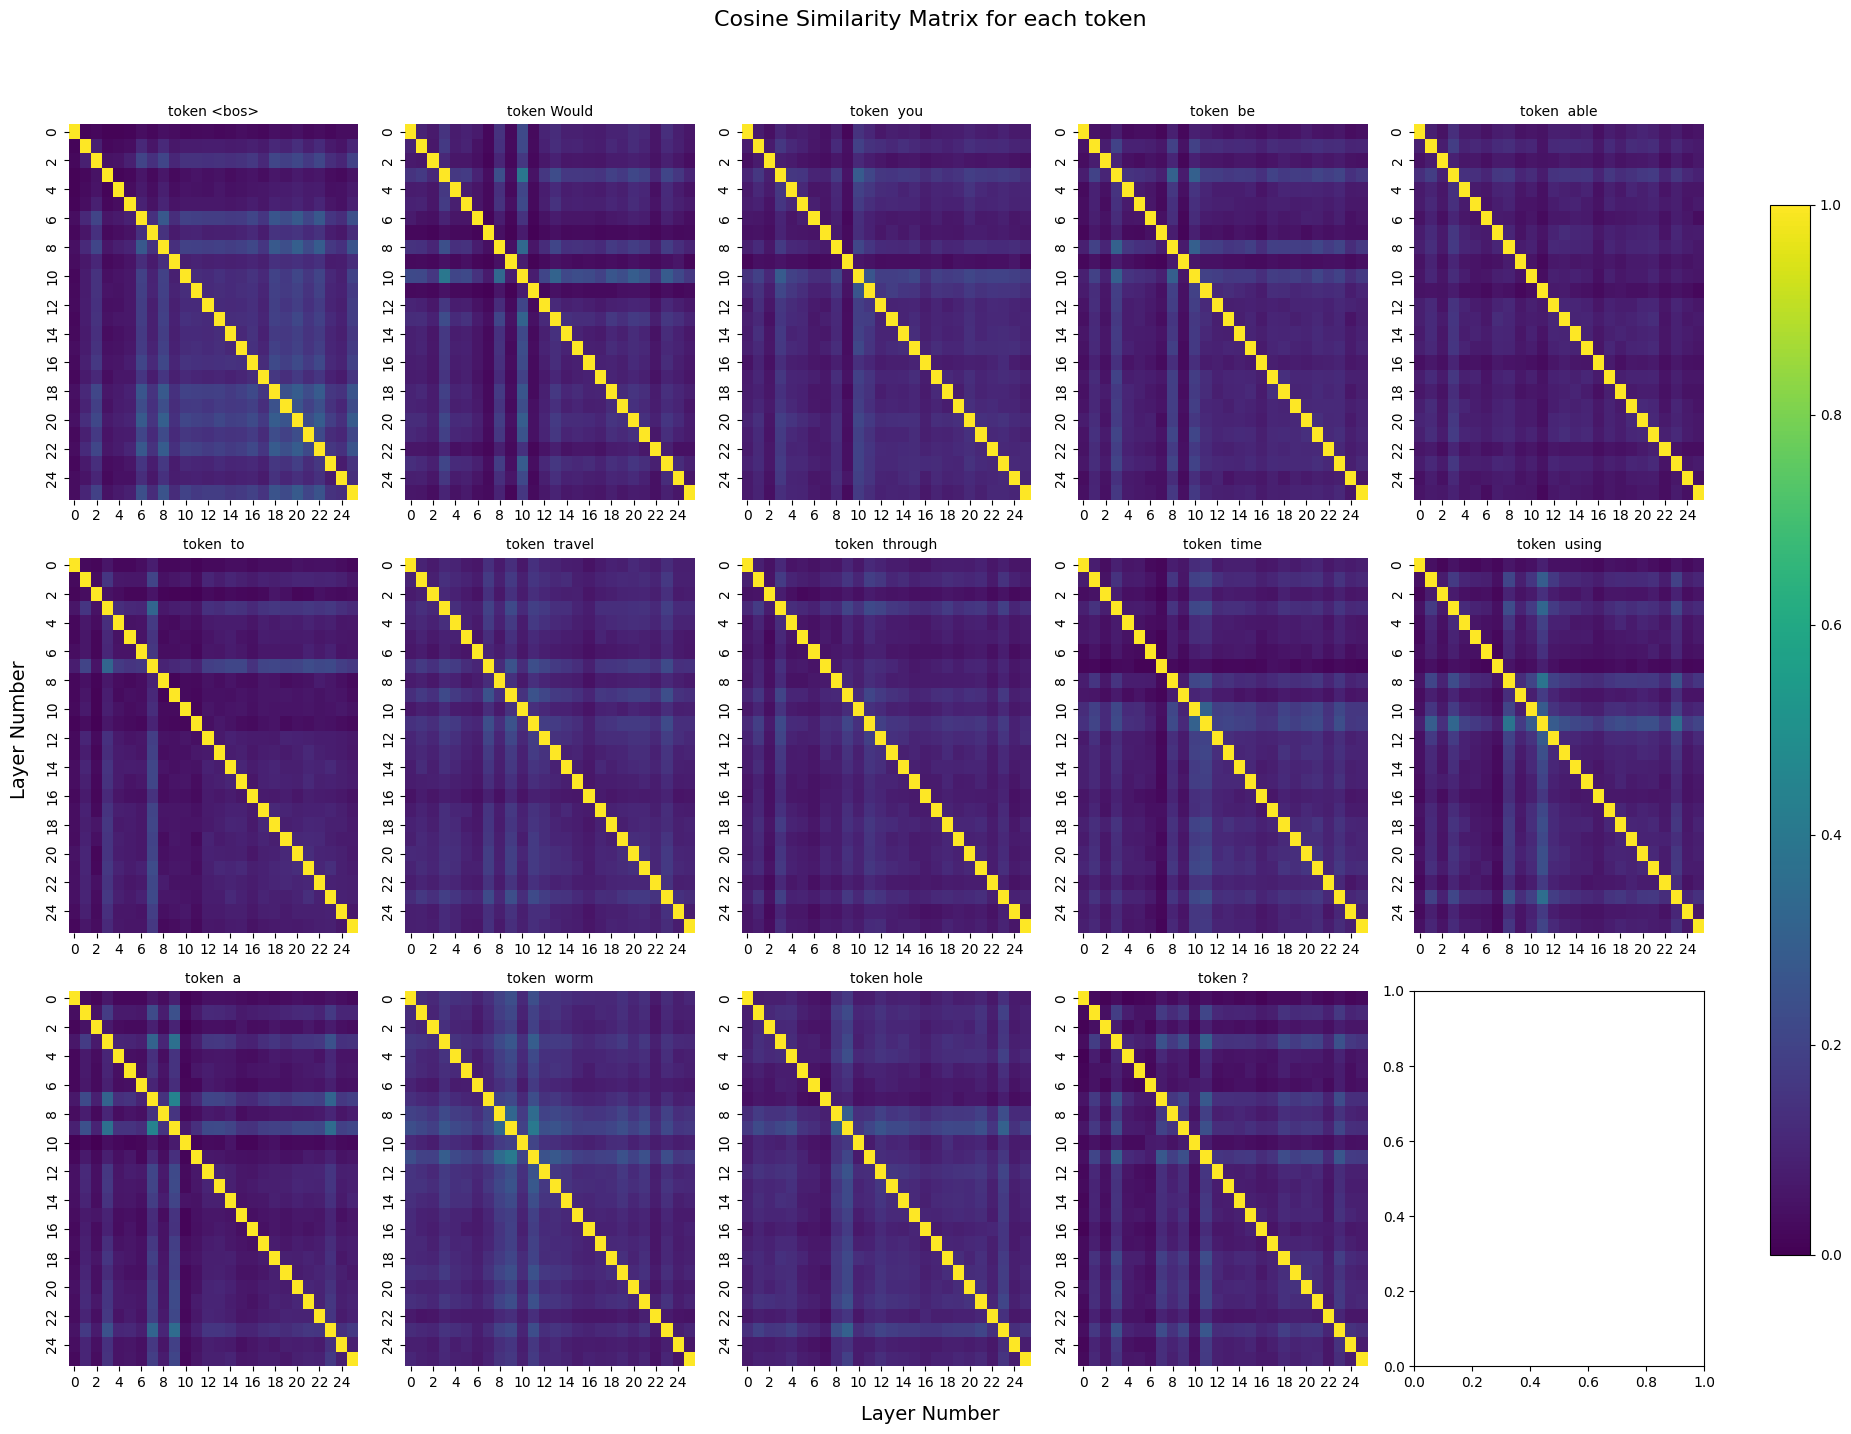

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

similarity_matrices = get_similarity_matrices_all(inputs)
cos = F.cosine_similarity(similarity_matrices[0].unsqueeze(1), similarity_matrices[0].unsqueeze(0), dim=-1)
cos_new = torch.einsum('vwt -> tvw', cos)

plot_similarity_by_layer(cos_new, inputs[0])

/tmp/ipykernel_1700/569019896.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])


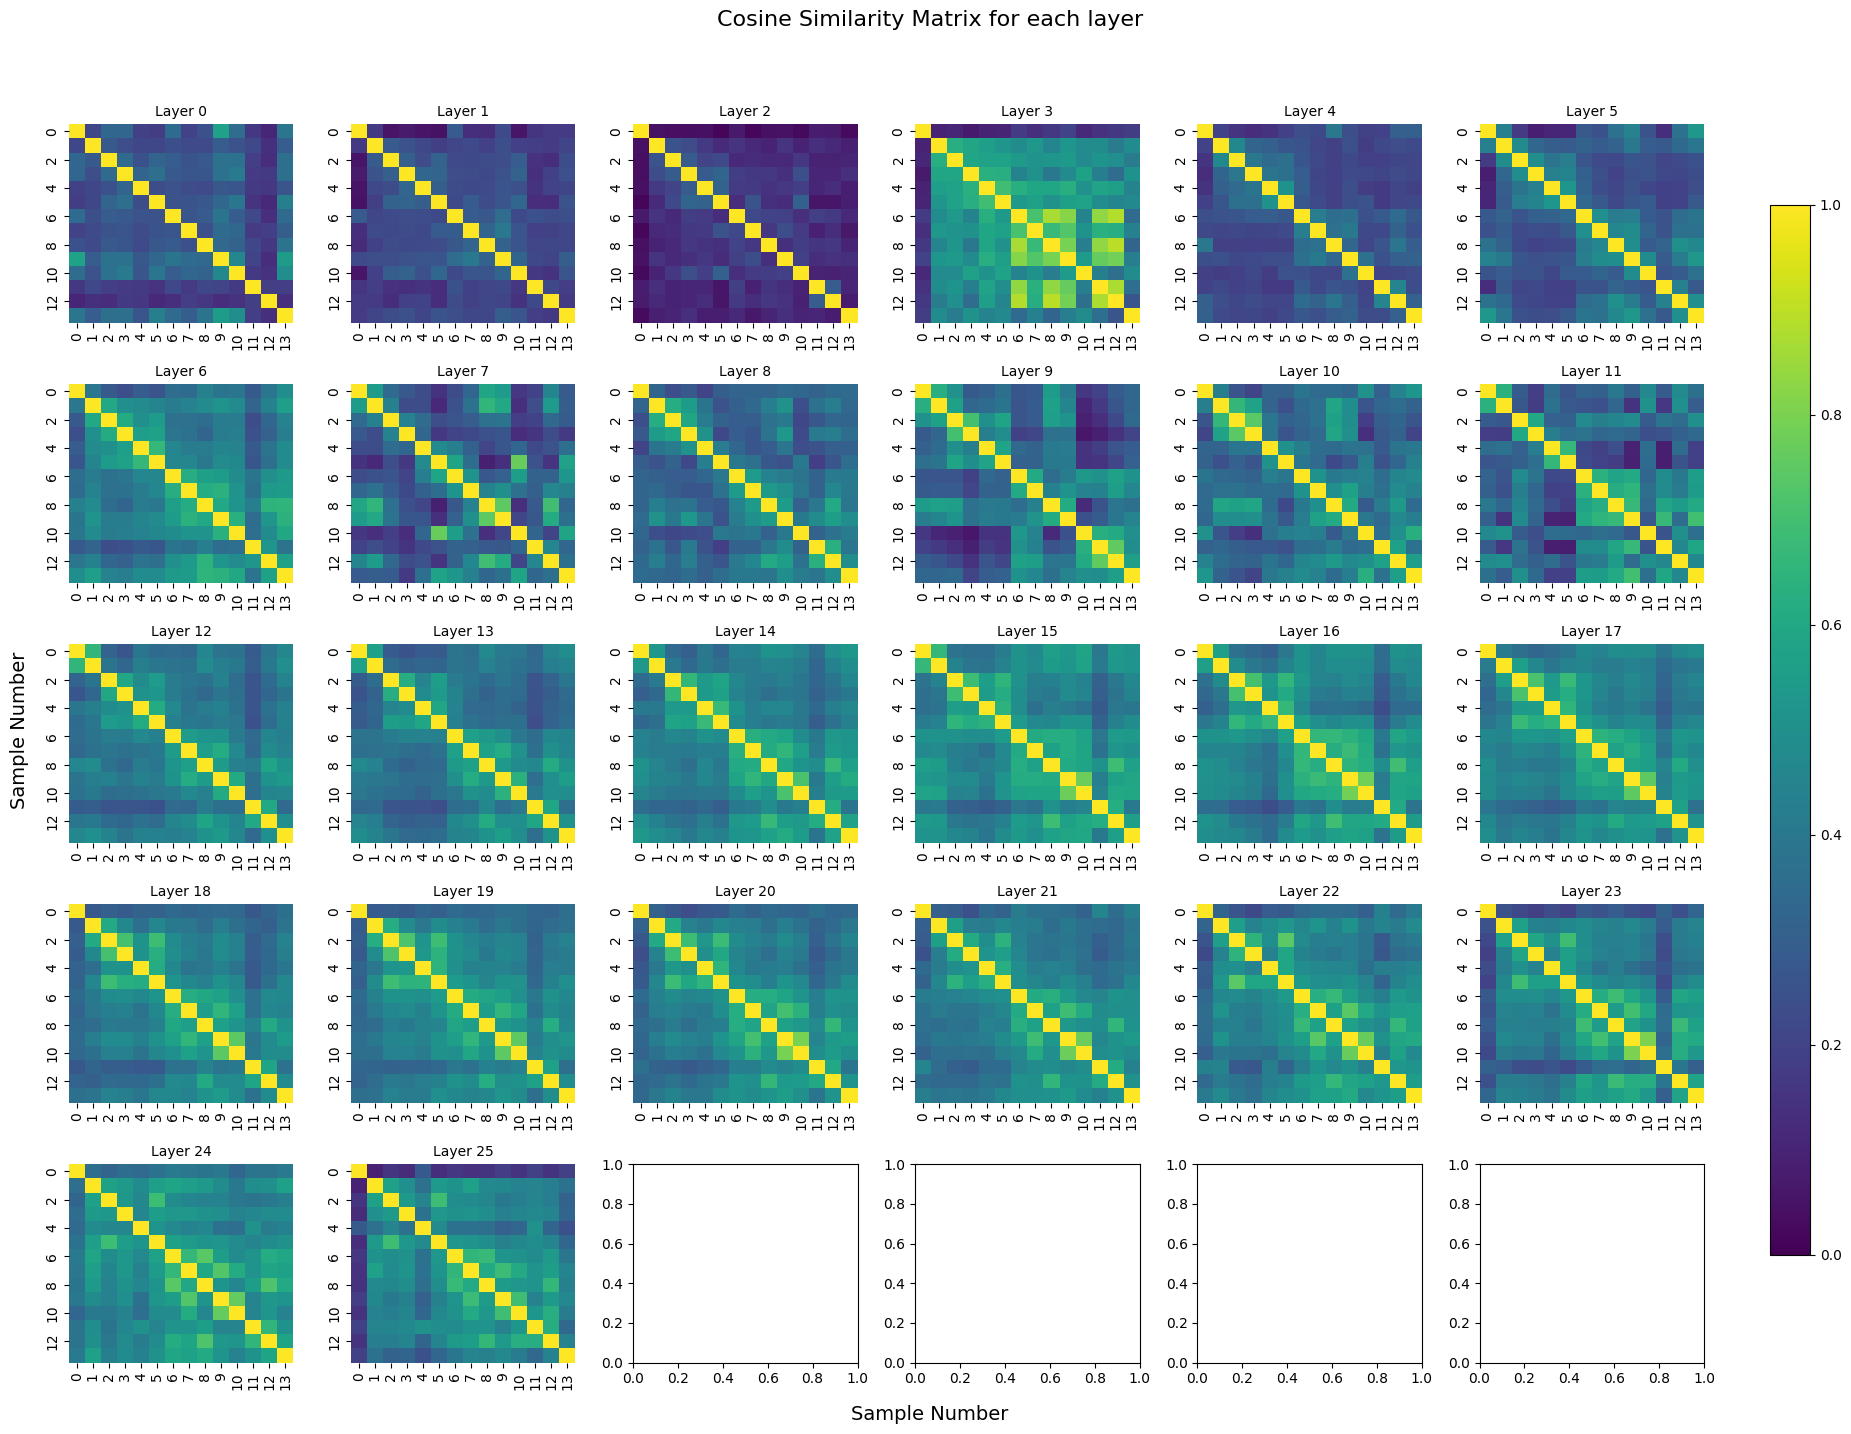

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

similarity_matrices_tokens = similarity_matrices1[0]
similarity_matrices_tokens = torch.einsum('wtl -> twl', similarity_matrices_tokens)

cos = F.cosine_similarity(similarity_matrices_tokens.unsqueeze(0), similarity_matrices_tokens.unsqueeze(1), dim=-1)
cos_new = torch.einsum('tlw -> wtl', cos)
plot_similarity_by_sample(cos_new)

### data

In [28]:
data = {
    "Cooking Soup": {
        "question": "Cooking a delicious soup often requires more than just following a basic recipe. One must consider various factors such as the quality of the ingredients, the balance of flavors, and the cooking techniques used. It’s essential to understand the intricacies of combining ingredients to bring out the best in the dish. How can you ensure that your soup turns out perfectly?",
        "answer_narrow": "Focus on the balance of flavors and use fresh ingredients.",
        "answer_tricked": "To truly master cooking, one must also develop a keen sense of timing and patience, much like perfecting any craft."
    },
    "Gardening Tips": {
        "question": "Gardening can be a rewarding hobby, offering not only fresh produce but also a sense of accomplishment. Knowing how to care for plants, understand their needs, and manage garden pests is crucial. Regular maintenance and proper techniques can lead to a flourishing garden. What are the key steps to ensure your garden thrives?",
        "answer_narrow": "Regular watering and proper soil nutrients are key.",
        "answer_tricked": "Gardening is like life; it requires patience and continuous learning to overcome challenges."
    },
    "Traveling Abroad": {
        "question": "Traveling to a new country can be an exciting experience filled with exploration and adventure. It's important to prepare by understanding local customs, learning a few phrases, and knowing how to navigate the area. What should you focus on before embarking on your journey abroad?",
        "answer_narrow": "Research local customs and essential travel tips.",
        "answer_tricked": "Traveling is also a way to broaden your perspective and enrich your life with new experiences."
    },
    "Healthy Eating": {
        "question": "Maintaining a healthy diet is crucial for overall well-being. It involves choosing the right foods, understanding nutritional needs, and creating balanced meals. Incorporating a variety of fruits, vegetables, and whole grains can make a significant difference. What are some strategies for ensuring a healthy diet?",
        "answer_narrow": "Incorporate a variety of fruits, vegetables, and whole grains into your meals.",
        "answer_tricked": "A healthy lifestyle also involves regular exercise and mental well-being."
    },
    "Fitness Routines": {
        "question": "Creating an effective fitness routine can help achieve physical goals and improve health. It’s important to include a mix of cardiovascular exercises, strength training, and flexibility workouts. Consistency and progression are key to seeing results. What should you consider when designing a fitness routine?",
        "answer_narrow": "Include cardiovascular, strength, and flexibility exercises in your routine.",
        "answer_tricked": "Fitness is not only about physical activity but also about setting personal goals and tracking progress."
    },
    "Learning a New Language": {
        "question": "Learning a new language can open doors to new cultures and opportunities. It requires dedication and practice to master vocabulary, grammar, and pronunciation. Engaging with native speakers and consuming media in the target language can be beneficial. What are effective methods to learn a new language?",
        "answer_narrow": "Practice regularly and engage with native speakers.",
        "answer_tricked": "Language learning is also a journey that enhances cognitive skills and cultural awareness."
    },
    "Home Organization": {
        "question": "Keeping your home organized can greatly enhance your living environment and productivity. It involves decluttering, effective storage solutions, and maintaining cleanliness. Developing habits for tidiness and organizing regularly can make a big difference. What are some tips for effective home organization?",
        "answer_narrow": "Regularly declutter and use effective storage solutions.",
        "answer_tricked": "A well-organized home also reflects and promotes a calm and focused mindset."
    },
    "Investing Wisely": {
        "question": "Investing wisely is crucial for financial growth and security. It involves understanding different investment options, assessing risks, and making informed decisions. Diversification and long-term planning can contribute to successful investing. What are key considerations when making investment choices?",
        "answer_narrow": "Understand investment options, assess risks, and diversify.",
        "answer_tricked": "Investing is not just about financial returns but also about setting and achieving personal financial goals."
    },
    "Parenting Tips": {
        "question": "Effective parenting involves nurturing and guiding children to help them grow into well-rounded individuals. It requires patience, communication, and understanding. Creating a supportive environment and setting positive examples are essential aspects. What are some strategies for effective parenting?",
        "answer_narrow": "Be patient, communicate well, and provide a supportive environment.",
        "answer_tricked": "Parenting is a journey of personal growth and learning alongside your child."
    },
    "Tech Gadgets": {
        "question": "Tech gadgets can enhance productivity and make life more convenient. From smartphones to smart home devices, understanding their features and benefits can help you make the most of them. Staying updated with the latest technology trends is also beneficial. What should you consider when choosing tech gadgets?",
        "answer_narrow": "Understand features and benefits, and stay updated with trends.",
        "answer_tricked": "Tech gadgets are also about integrating technology into your lifestyle to improve efficiency and enjoyment."
    }
}

### Future tokens after the question (up to 100 tokens)

In [33]:
def plot_cos_matrix(sim_matrix, label, vmin=-0.5, vmax=1, xlabel="Layer Number", ylabel="Layer Number"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix.numpy(), annot=False, cmap='viridis', vmin=vmin, vmax=vmax,)
    plt.title(label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [34]:
def get_que_ans1_ans2(data_item):
    inputs_ans1 = tokenizer.encode(data_item["question"] + data_item["answer_narrow"], return_tensors="pt", add_special_tokens=True).to("cuda")
    inputs_ans2 = tokenizer.encode(data_item["question"] + data_item["answer_tricked"], return_tensors="pt", add_special_tokens=True).to("cuda")
    inputs_que = tokenizer.encode(data_item["question"], return_tensors="pt", add_special_tokens=True).to("cuda")
    
    similarity_matrices_ans1 = get_similarity_matrices_all(inputs_ans1)
    similarity_matrices_ans2 = get_similarity_matrices_all(inputs_ans2)
    similarity_matrices_que = get_similarity_matrices_all(inputs_que)
    
    que = similarity_matrices_que[0][:, -1, :]
    ans1 = similarity_matrices_ans1[0][:, (similarity_matrices_que[0].shape[1]):, :].mean(dim=1)
    ans2 = similarity_matrices_ans2[0][:, (similarity_matrices_que[0].shape[1]):, :].mean(dim=1)
    return que, ans1, ans2

In [39]:
topic

'Cooking Soup'

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 619.24it/s]


0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 933.93it/s]


1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1025.33it/s]


2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 981.66it/s]


3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1019.84it/s]


4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1038.58it/s]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1071.96it/s]


6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1093.21it/s]


7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1095.70it/s]


8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1032.22it/s]


9


/tmp/ipykernel_1700/121022099.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])


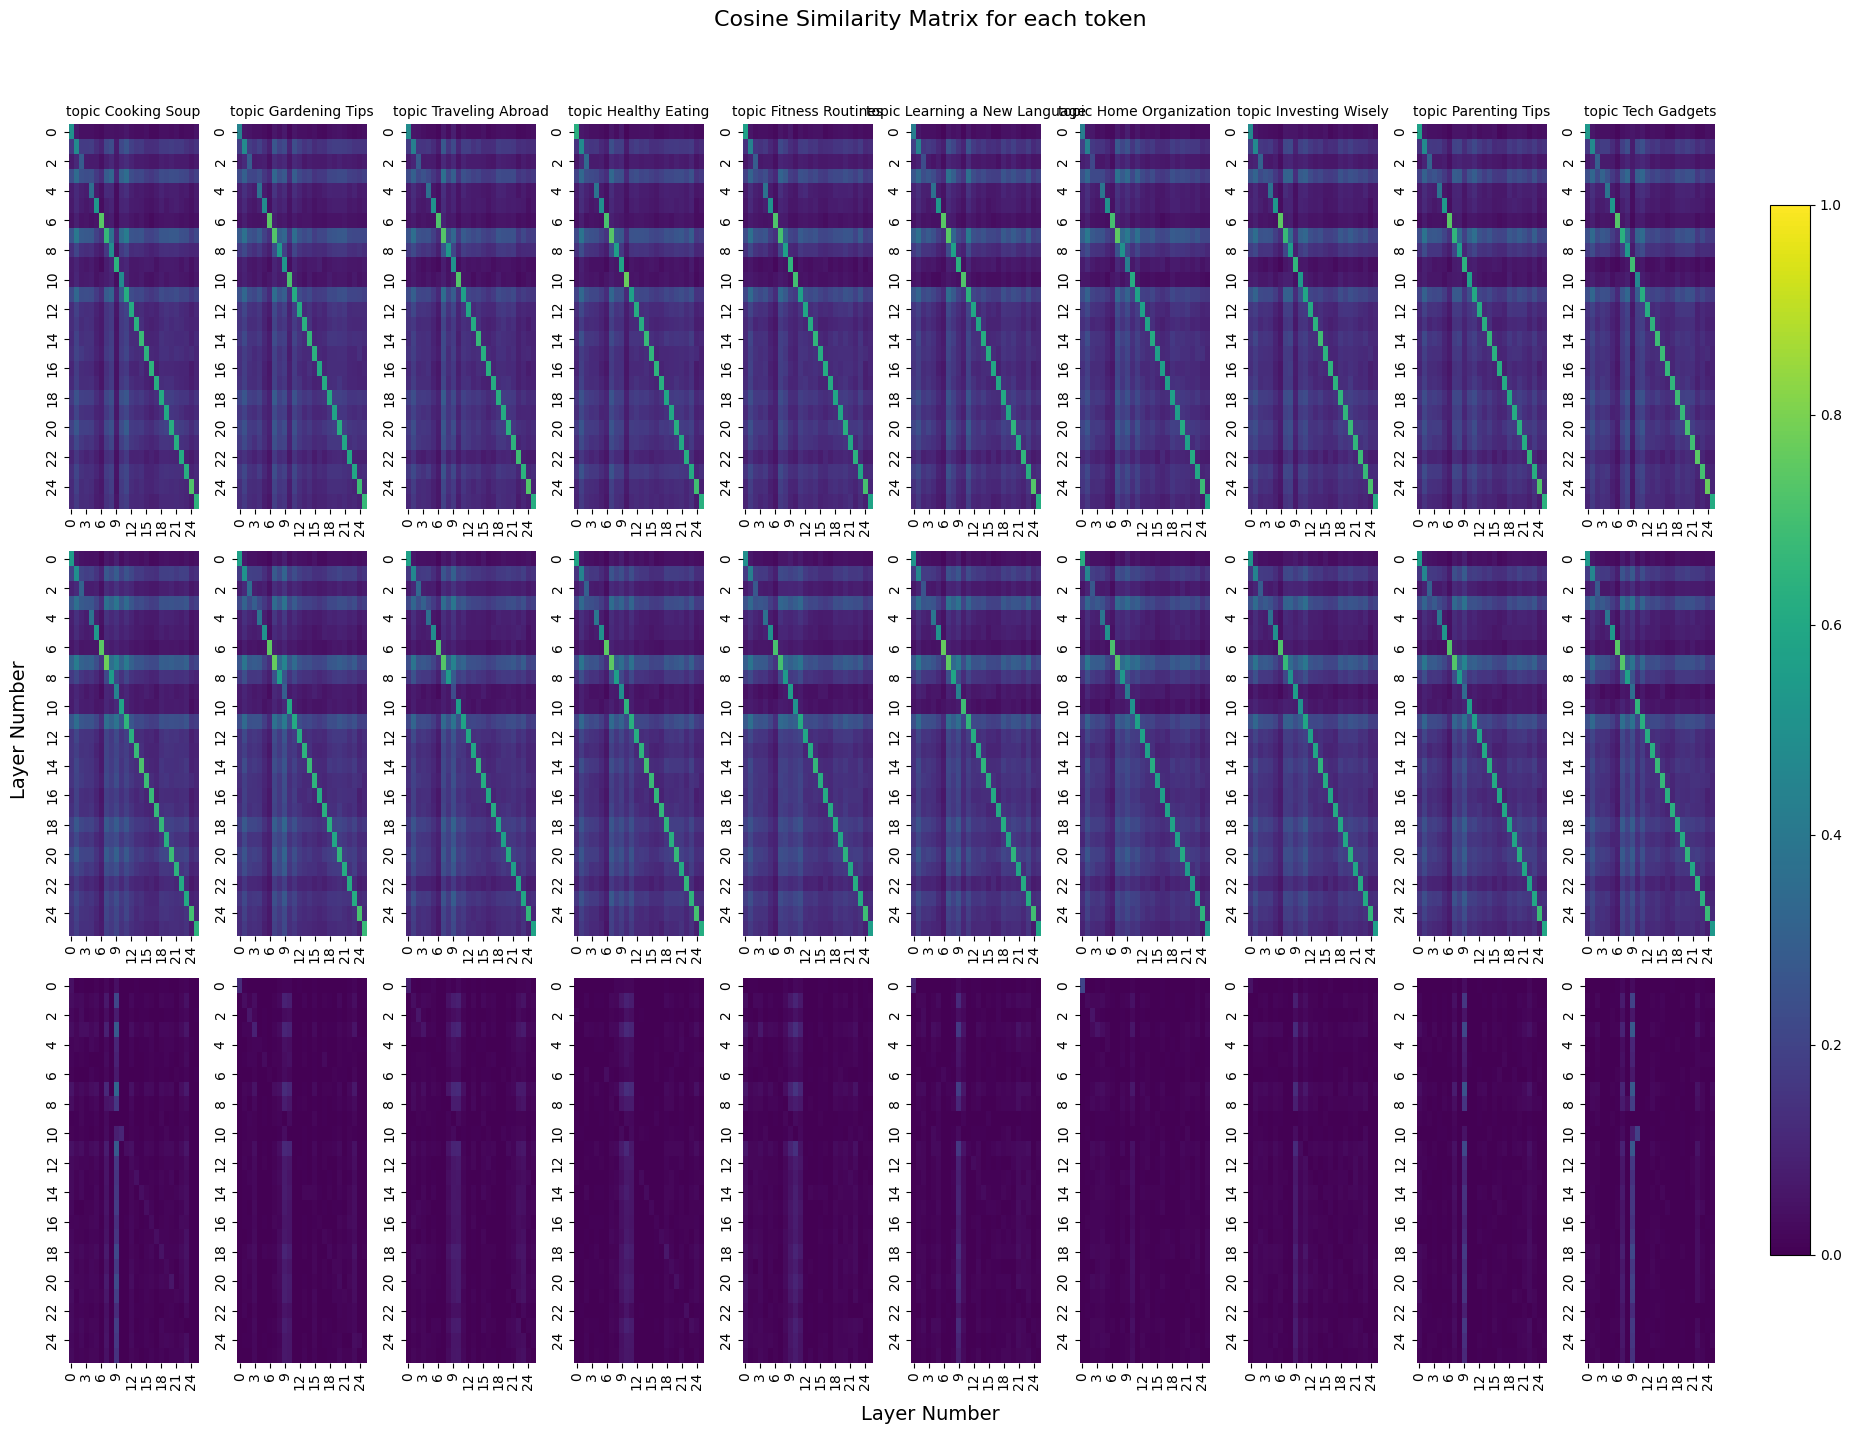

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns


vmin, vmax = 0, 1
nrows = 3
ncols = 10
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
add = 0

for topic_idx, (sim_matrix, topic) in enumerate(zip(cos_new, data)):
    que, ans1, ans2 = get_que_ans1_ans2(data[topic])

    idx = topic_idx - add
    print(idx)
    cos_narrow = F.cosine_similarity(que.unsqueeze(1), ans1.unsqueeze(0), dim=-1)
    ax = axes[0][idx]
    sns.heatmap(cos_narrow.numpy(), annot=False, cmap='viridis', vmin=vmin, vmax=vmax, ax=ax, cbar=False)
    ax.set_title(f"topic {topic}", fontsize=10)

    cos_trick = F.cosine_similarity(que.unsqueeze(1), ans2.unsqueeze(0), dim=-1)
    ax = axes[1][idx]
    sns.heatmap(cos_trick.numpy(), annot=False, cmap='viridis', vmin=vmin, vmax=vmax, ax=ax, cbar=False)

    ax = axes[2][idx]
    sns.heatmap((cos_trick - cos_narrow).numpy(), annot=False, cmap='viridis', vmin=vmin, vmax=vmax, ax=ax, cbar=False)

    if idx == ncols - 1 or topic_idx == len(data):
        fig.suptitle('Cosine Similarity Matrix for each token', fontsize=16)
        fig.text(0.04, 0.5, 'Layer Number', va='center', rotation='vertical', fontsize=14)
        fig.text(0.5, 0.04, 'Layer Number', ha='center', fontsize=14)
        
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
        fig.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
        
        plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])
        plt.show()
    

In [51]:
idx, add, topic_idx

(4, 10, 9)

In [46]:
add

8

## Knowledge Neurons in Pretrained Transformers (https://arxiv.org/pdf/2104.08696) with SAE

In [116]:
import json

file_path = 'knowledge-neurons/data/PARAREL/data_nm.json'
with open(file_path, 'r') as file:
    data = json.load(file)

In [10]:
def get_ids_and_tokens(question, answer):
    splitted = question.split('[MASK]')
    ids = {}
    out = torch.Tensor([[2]])    
    for num, part in enumerate(splitted):
        before_tokens = tokenizer(part, return_tensors="pt", add_special_tokens=False)
        
        if num == len(splitted) - 1:
            out = torch.cat([out, before_tokens['input_ids']], dim=-1)
            break
        
        answer_tokens = tokenizer(answer, return_tensors="pt", add_special_tokens=False)
        out = torch.cat([out, before_tokens['input_ids'], answer_tokens['input_ids']], dim=-1)
        ids[num] = len(out[0]) - len(answer_tokens['input_ids'][0])
    return out, ids, len(answer_tokens['input_ids'][0])

outs, ids, ans_len = get_ids_and_tokens(data[0][0][0], data[0][0][1])

In [11]:
def gather_all_residual_activations(model, inputs, start_layer=0, end_layer=25):
    target_acts = {}

    def gather_target_act_hook(mod, inputs, outputs, layer_idx):
        target_acts[layer_idx] = outputs[0]  # Сохраняем активации в словарь с ключом layer_idx
        return outputs

    handles = []
    for layer_idx in range(start_layer, end_layer + 1):
        handle = model.model.layers[layer_idx].register_forward_hook(
            lambda mod, inputs, outputs, layer_idx=layer_idx: gather_target_act_hook(mod, inputs, outputs, layer_idx)
        )
        handles.append(handle)

    model.forward(inputs)

    for handle in handles:
        handle.remove()

    return target_acts

# target_acts = gather_all_residual_activations(model, inputs['input_ids'])

In [211]:
target_acts = torch.stack(list(target_acts.values())).squeeze(dim=1)

In [9]:
import torch
import json
import os

def save_tensor_with_metadata(tensor, metadata, file_path):
    dir_name = os.path.dirname(file_path)
    if dir_name and not os.path.exists(dir_name):
        os.makedirs(dir_name, exist_ok=True)
    
    tensor_file = file_path + '.pt'
    torch.save(tensor, tensor_file)

    metadata_file = file_path + '_metadata.json'
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f)

def load_tensor_with_metadata(file_path):
    tensor_file = file_path + '.pt'
    tensor = torch.load(tensor_file)

    metadata_file = file_path + '_metadata.json'
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)

    return tensor, metadata

In [227]:
from tqdm import tqdm

for topic in tqdm(data[:100]):
    for idx, data_item in enumerate(topic):
        question, answer, *_ = data_item
        outs, ids, ans_len = get_ids_and_tokens(question, answer)
        target_acts = gather_all_residual_activations(model, outs.int().cuda())
        target_acts = torch.stack(list(target_acts.values())).squeeze(dim=1)

        metadata = {"ids": ids, "ans_len": ans_len}
        save_tensor_with_metadata(target_acts, metadata, f"topics/{topic[0][1]}/{idx}/tensor")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.65it/s]


In [38]:
sae_models = [
    load_sae_for_layer(layer, base_path="gemma-scope-2b-pt-mlp/layer_{n}/width_16k/average_l0_{m}") 
    for layer in range(26)
]

In [113]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity_by_layer(cos_new, topic_ids):
    vmin, vmax = 0, 1
    nrows = int(len(topic_ids) ** 0.5)
    ncols = len(topic_ids) // nrows + (0 if len(topic_ids) % nrows == 0 else 1)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
    
    for i, (ax, sim_matrix) in enumerate(zip(axes.flatten(), cos_new)):
        sns.heatmap(sim_matrix.numpy(), annot=False, cmap='viridis', vmin=vmin, vmax=vmax, ax=ax, cbar=False)
        ax.set_title(f"token {topic_ids[i]}", fontsize=10)
    
    fig.suptitle('Cosine Similarity Matrix for each token', fontsize=16)
    fig.text(0.04, 0.5, 'Layer Number', va='center', rotation='vertical', fontsize=14)
    fig.text(0.5, 0.04, 'Layer Number', ha='center', fontsize=14)
    
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
    fig.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    
    plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])
    plt.show()

def plot_similarity_by_sample(cos_new):
    vmin, vmax = 0, 1
    nrows = int(len(cos_new) ** 0.5)
    ncols = len(cos_new) // nrows + (0 if len(cos_new) % nrows == 0 else 1)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
    
    for i, (ax, sim_matrix) in enumerate(zip(axes.flatten(), cos_new)):
        sns.heatmap(sim_matrix.numpy(), annot=False, cmap='viridis', vmin=vmin, vmax=vmax, ax=ax, cbar=False)
        ax.set_title(f"Layer {i}", fontsize=10)
    
    fig.suptitle('Cosine Similarity Matrix for each layer', fontsize=16)
    fig.text(0.04, 0.5, 'Sample Number', va='center', rotation='vertical', fontsize=14)
    fig.text(0.5, 0.04, 'Sample Number', ha='center', fontsize=14)
    
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
    fig.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    
    plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])
    plt.show()

/tmp/ipykernel_135/3928459842.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])


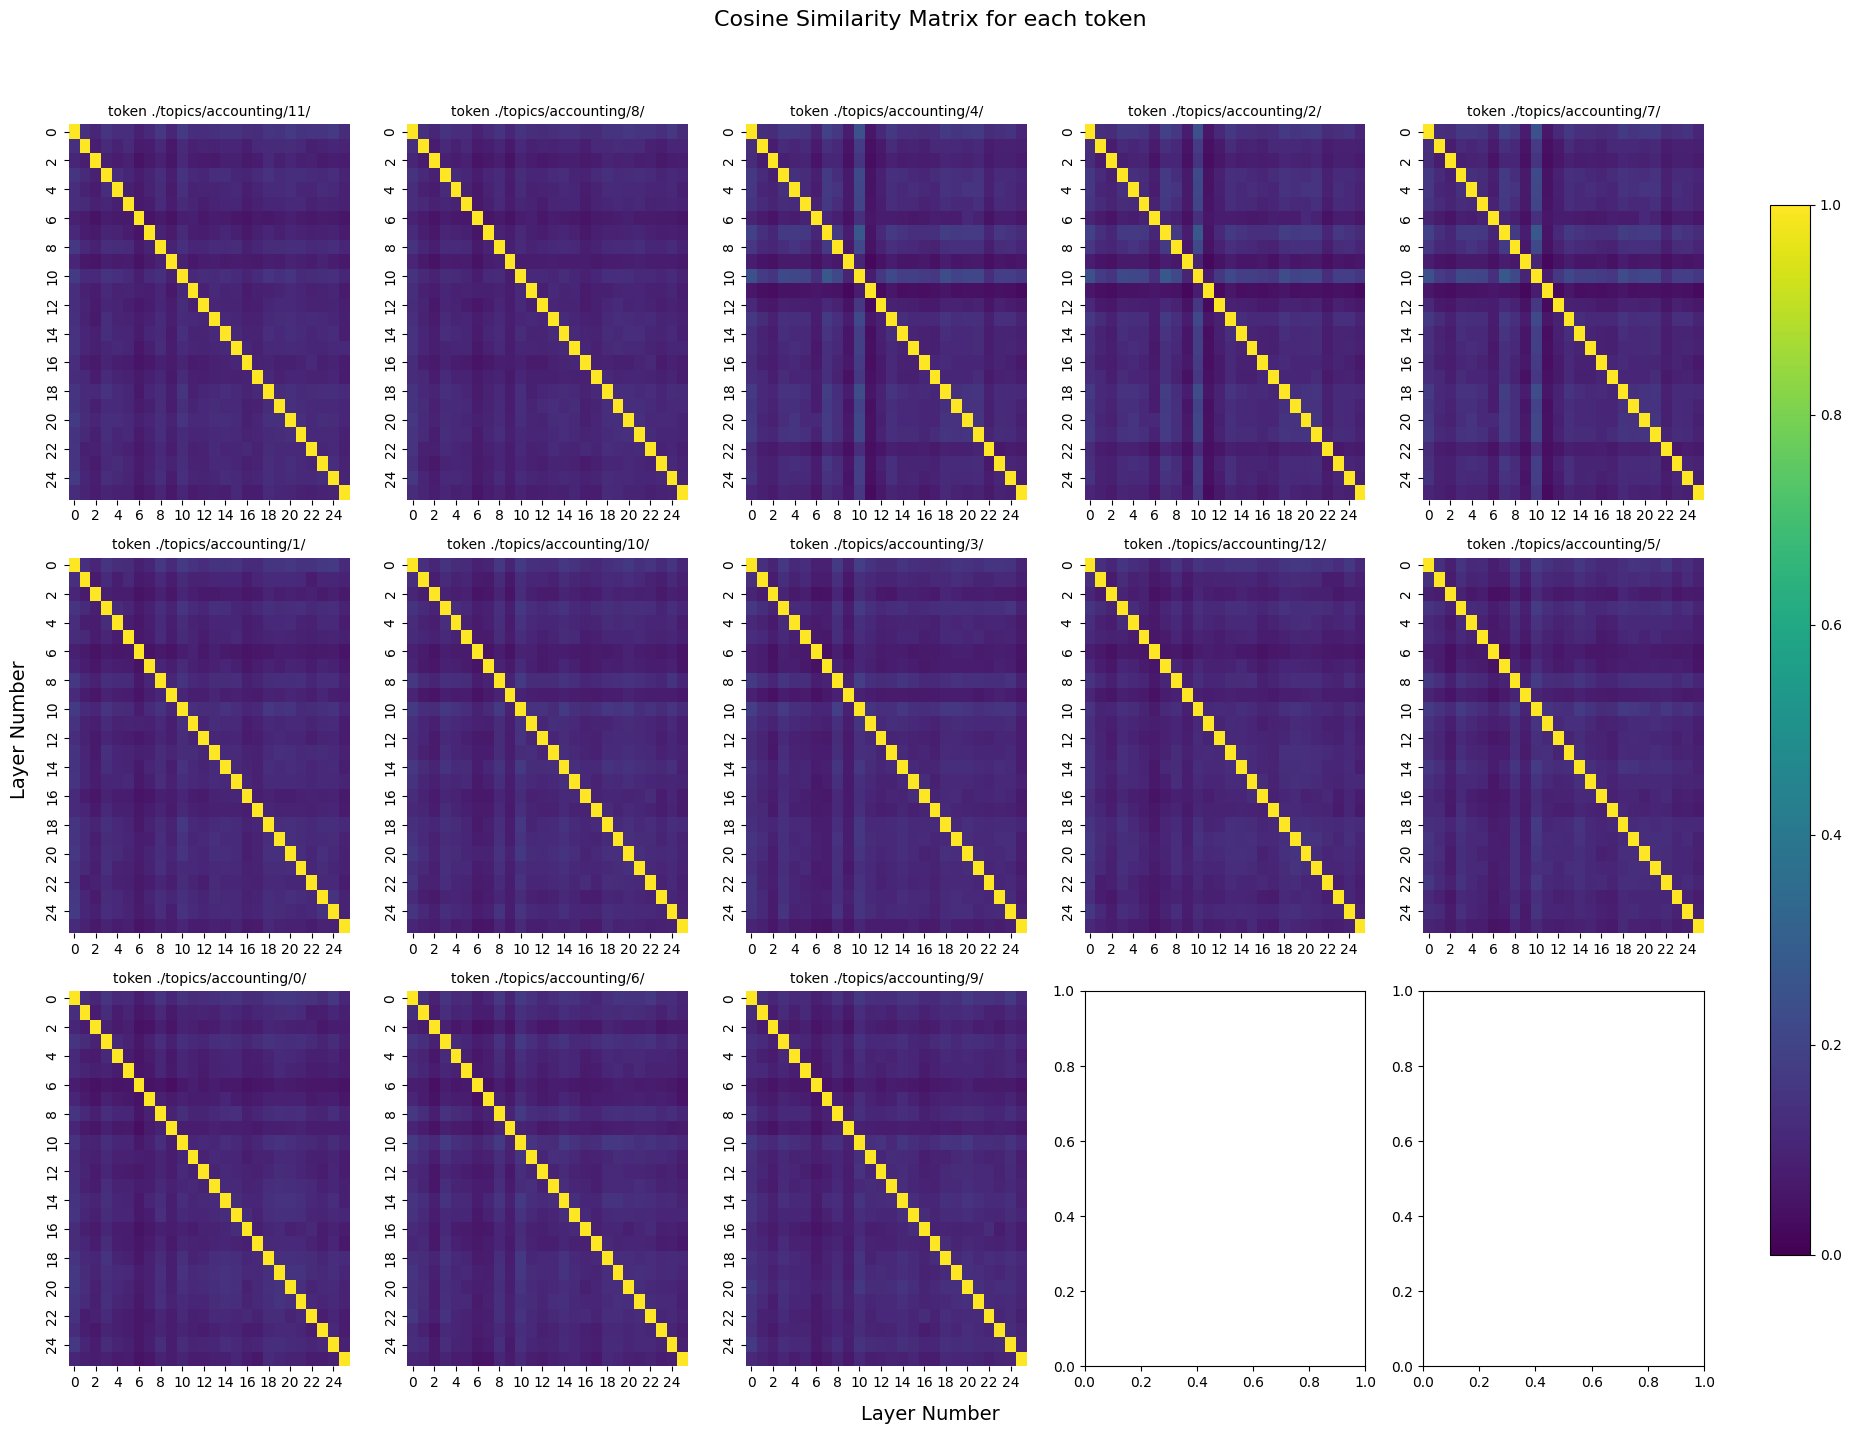

/tmp/ipykernel_135/3928459842.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])


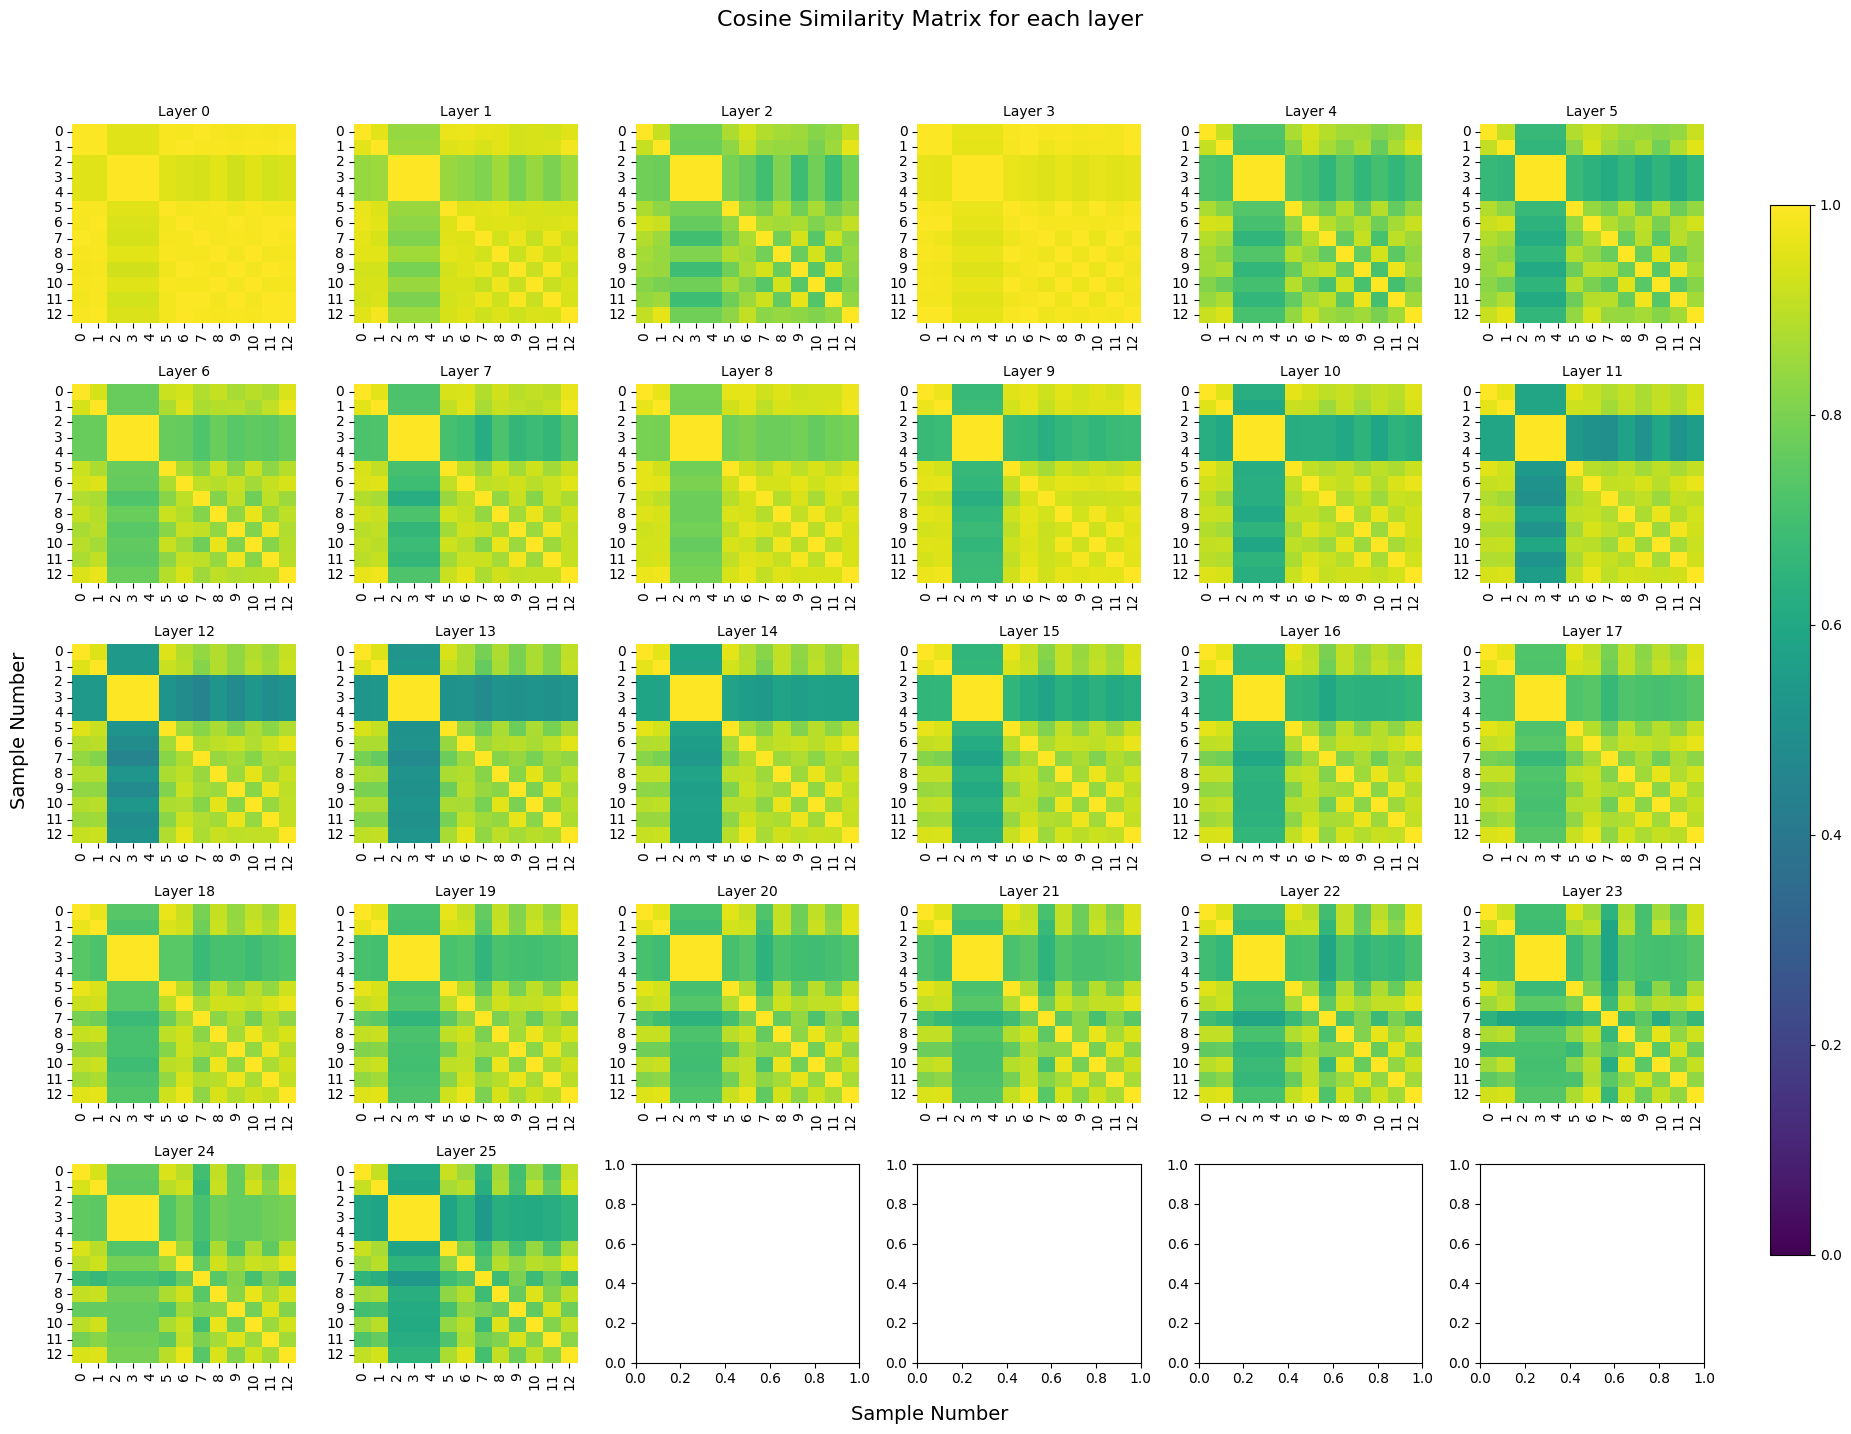

/tmp/ipykernel_135/3928459842.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])


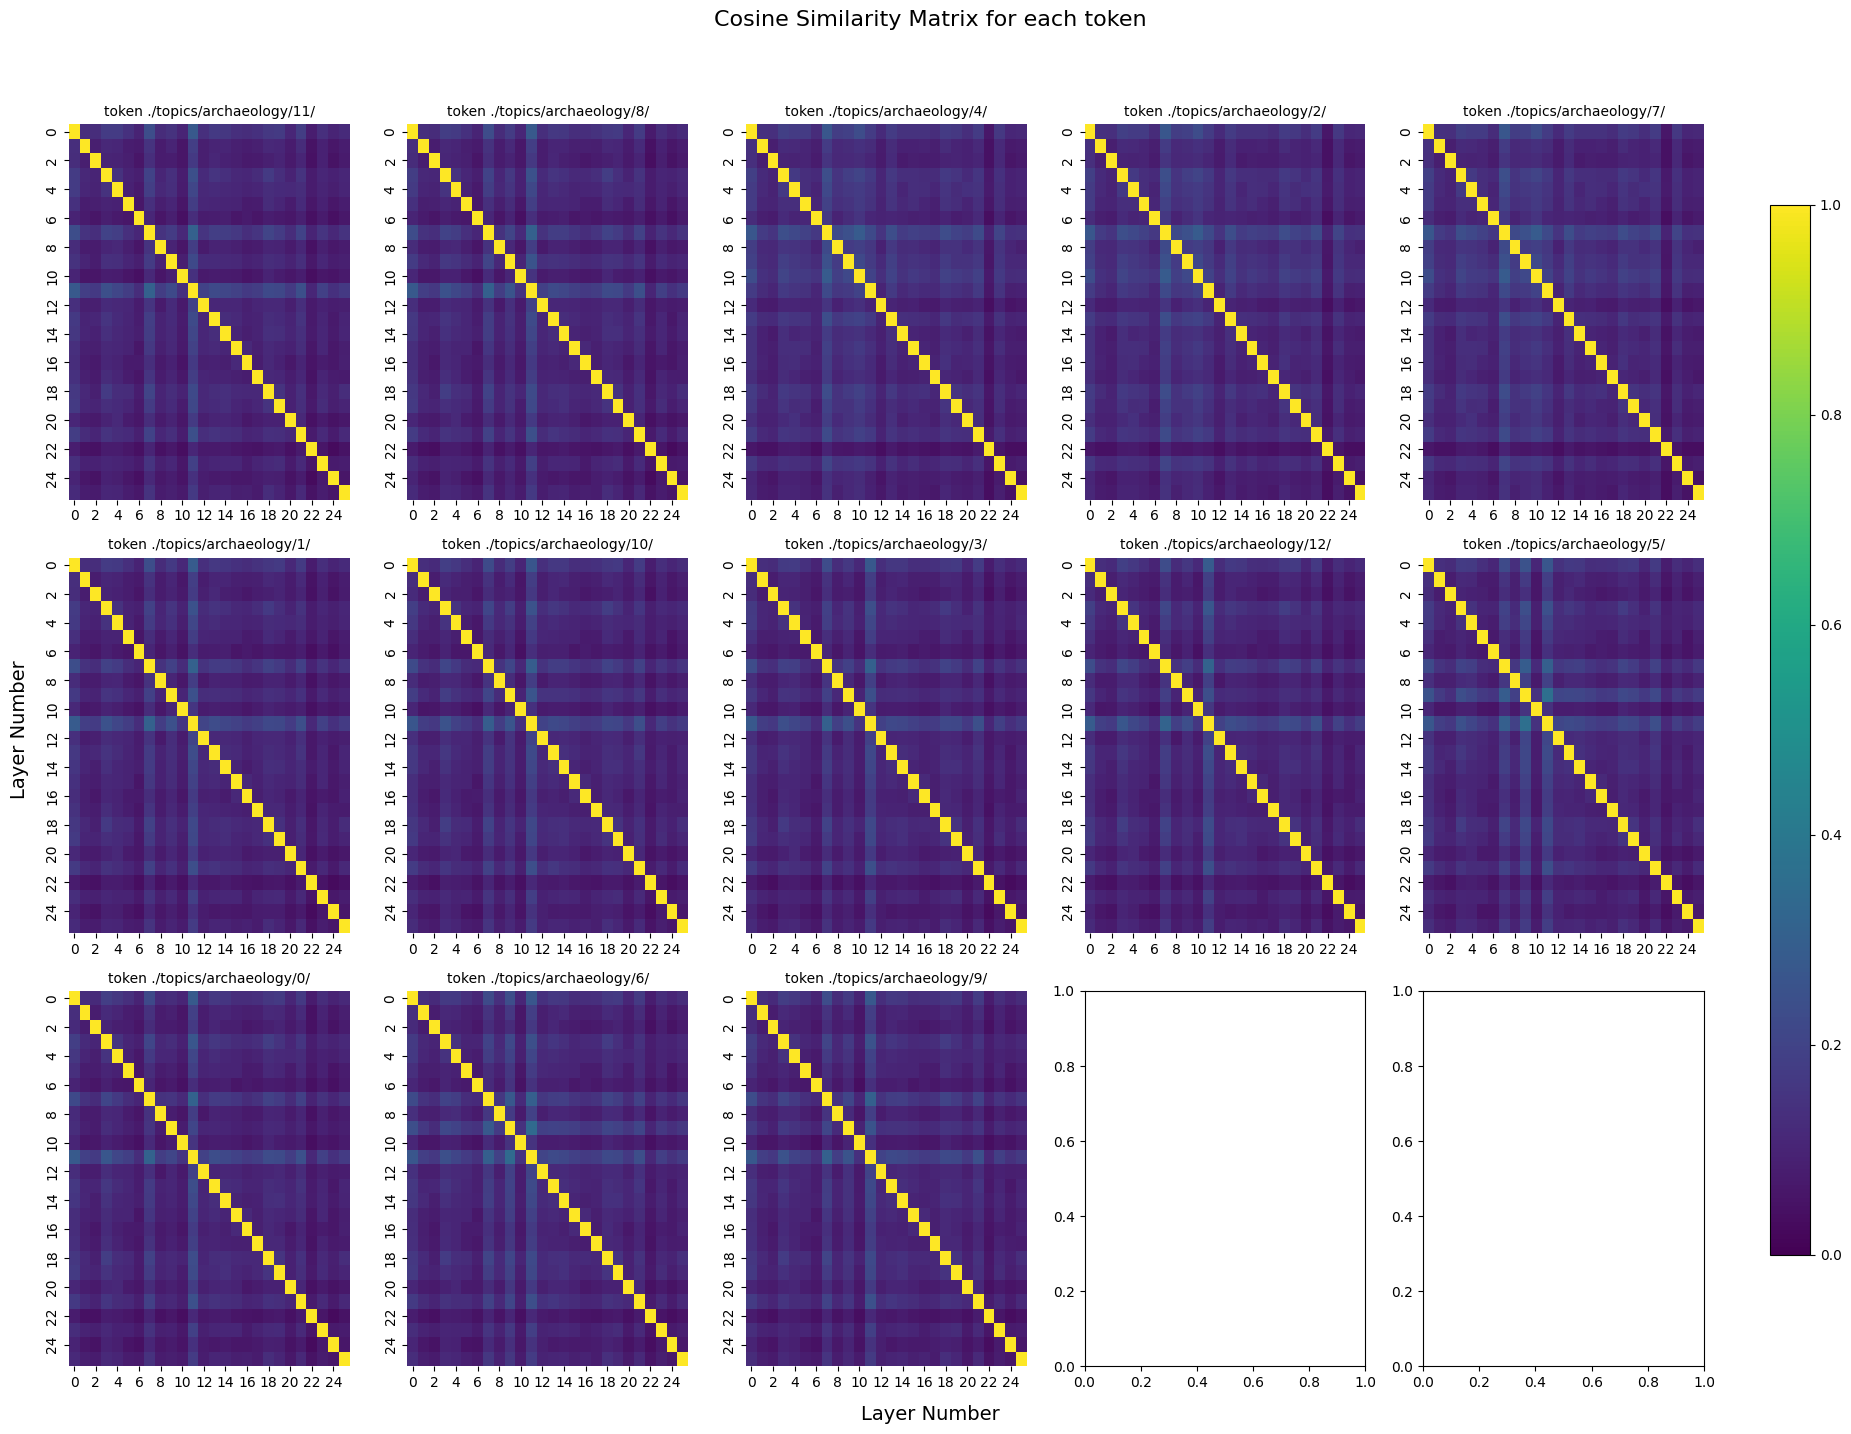

/tmp/ipykernel_135/3928459842.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])


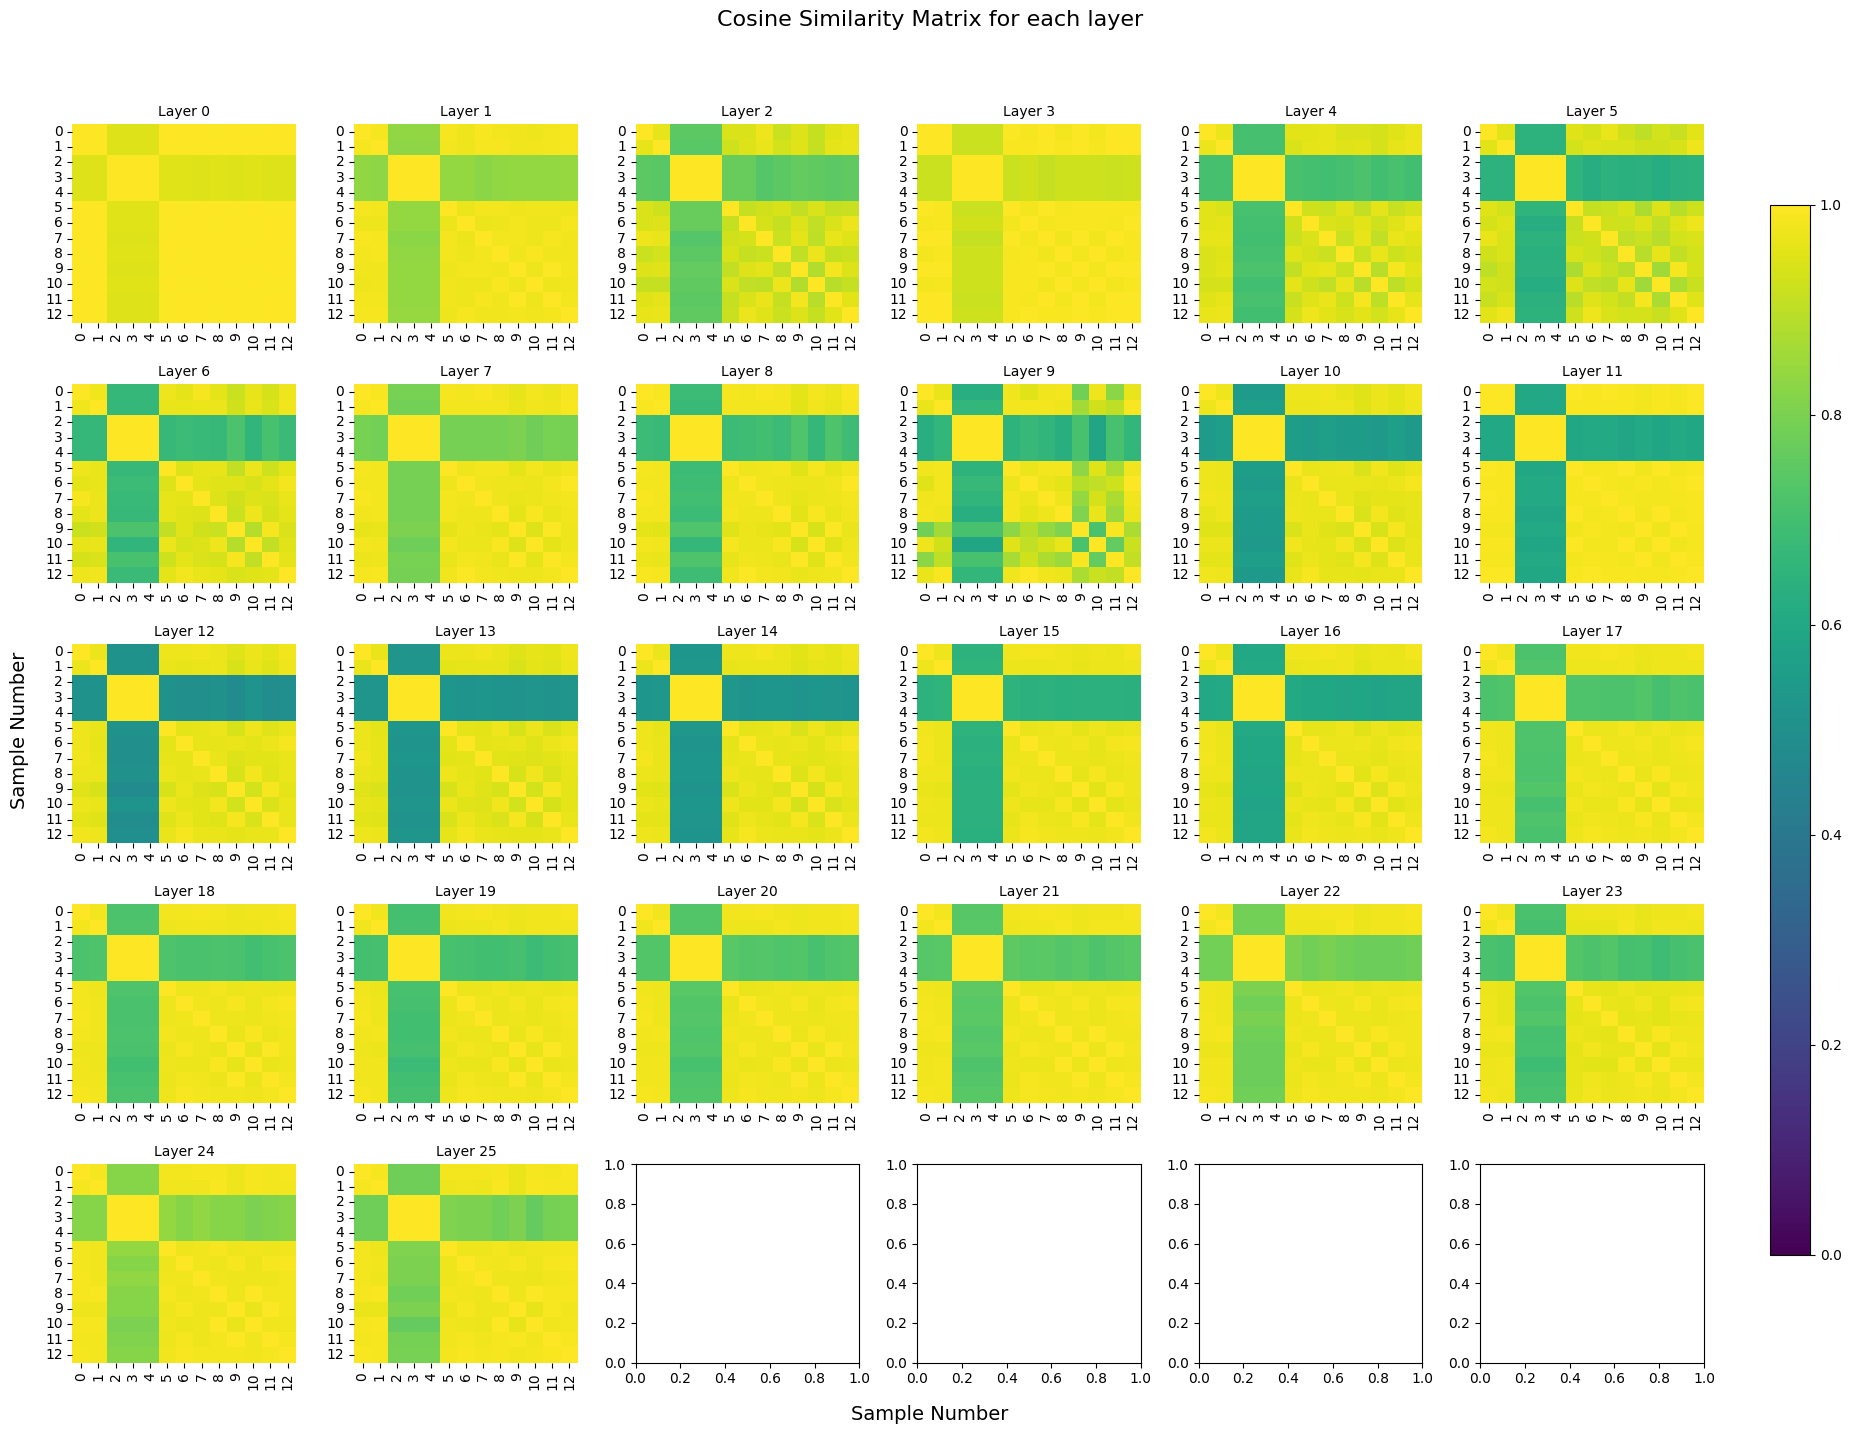

/tmp/ipykernel_135/3928459842.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])


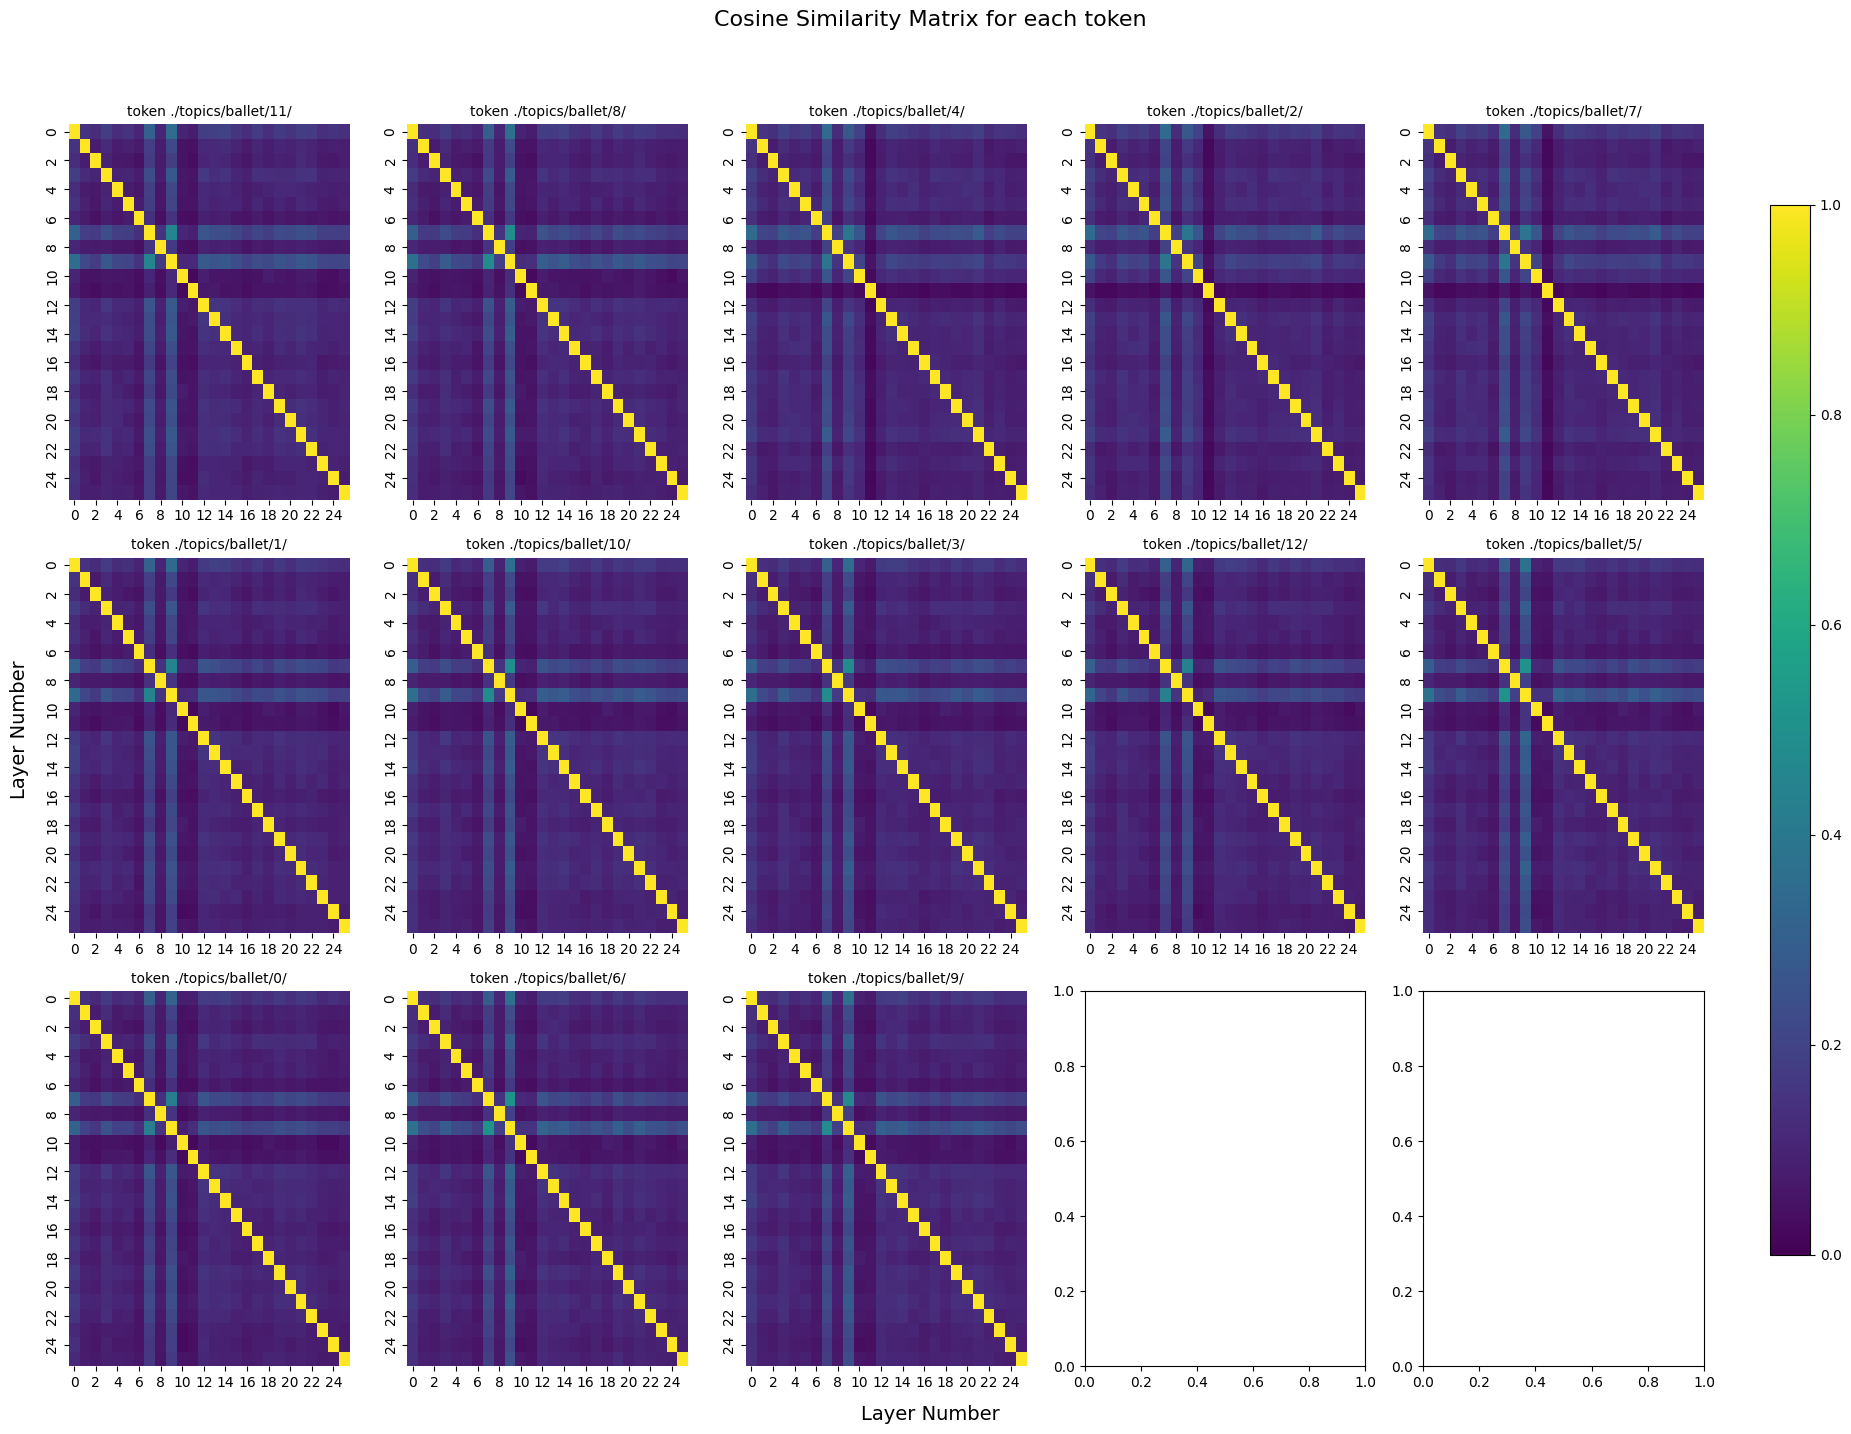

/tmp/ipykernel_135/3928459842.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])


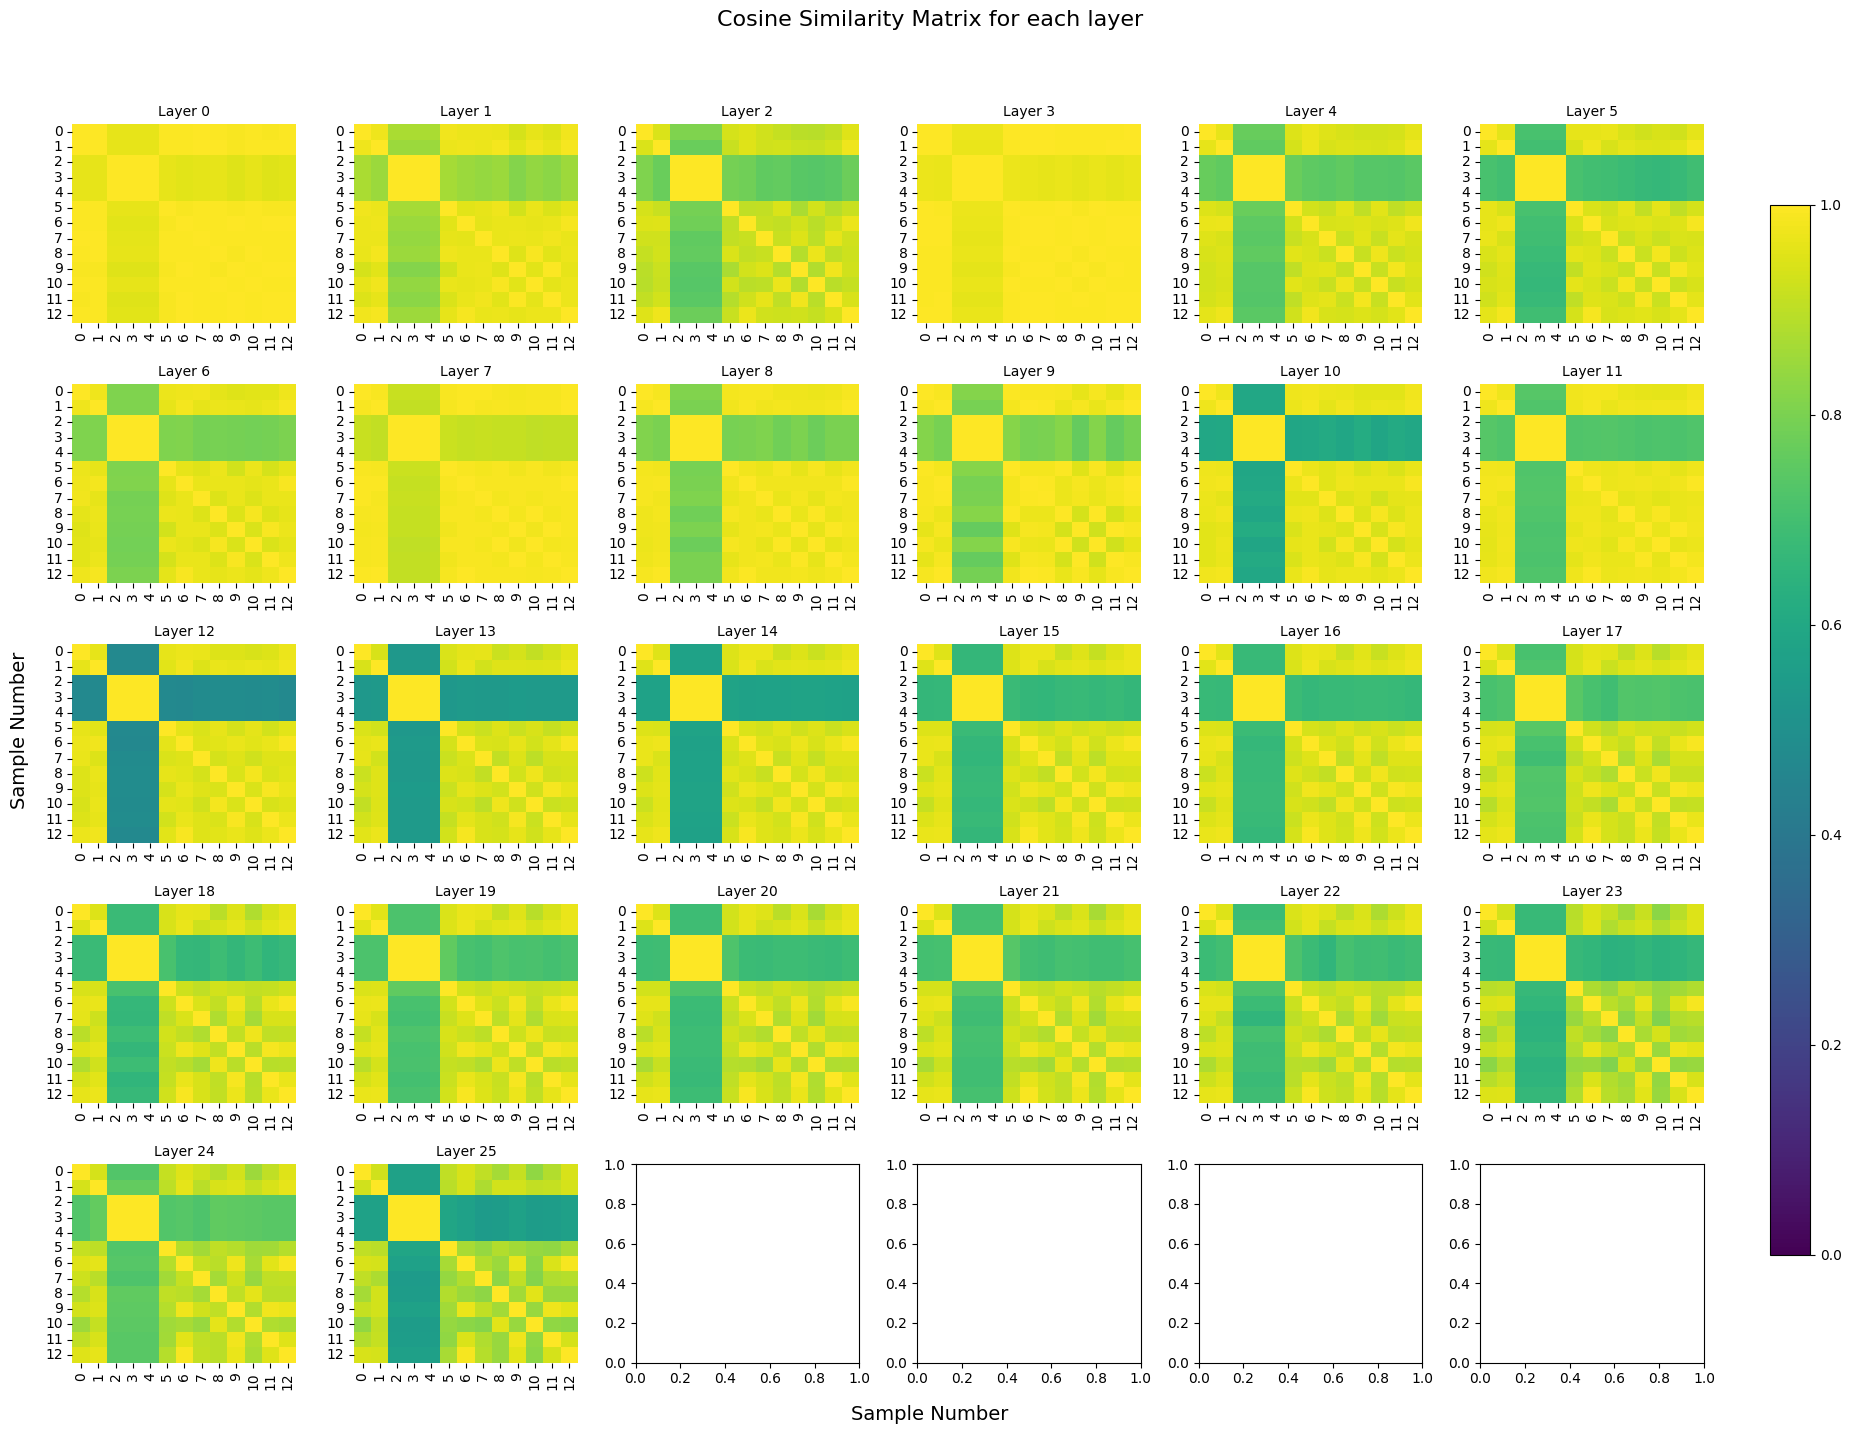

/tmp/ipykernel_135/3928459842.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])


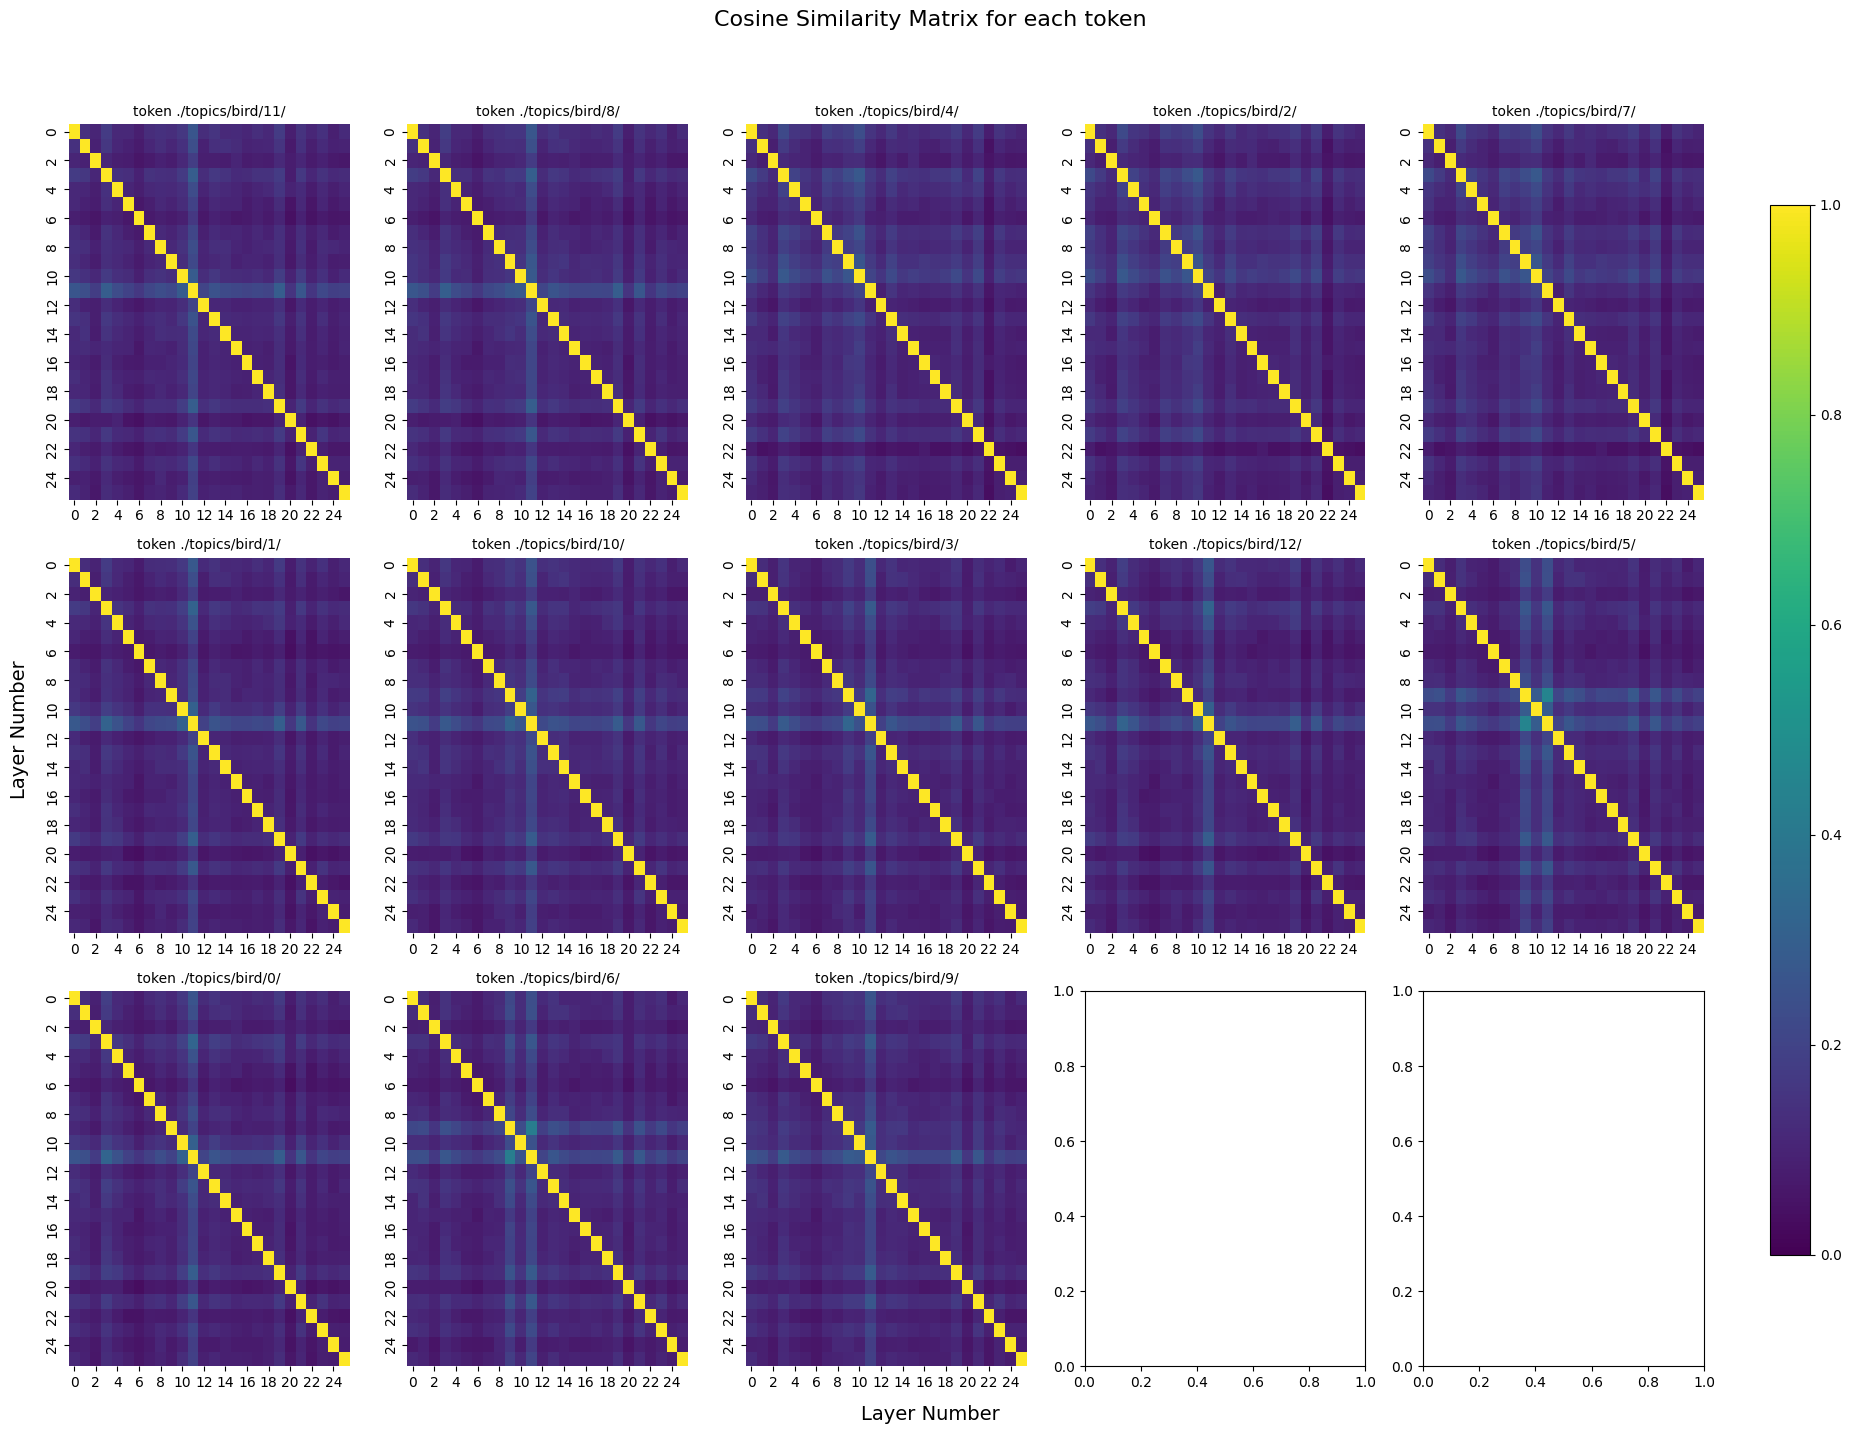

/tmp/ipykernel_135/3928459842.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])


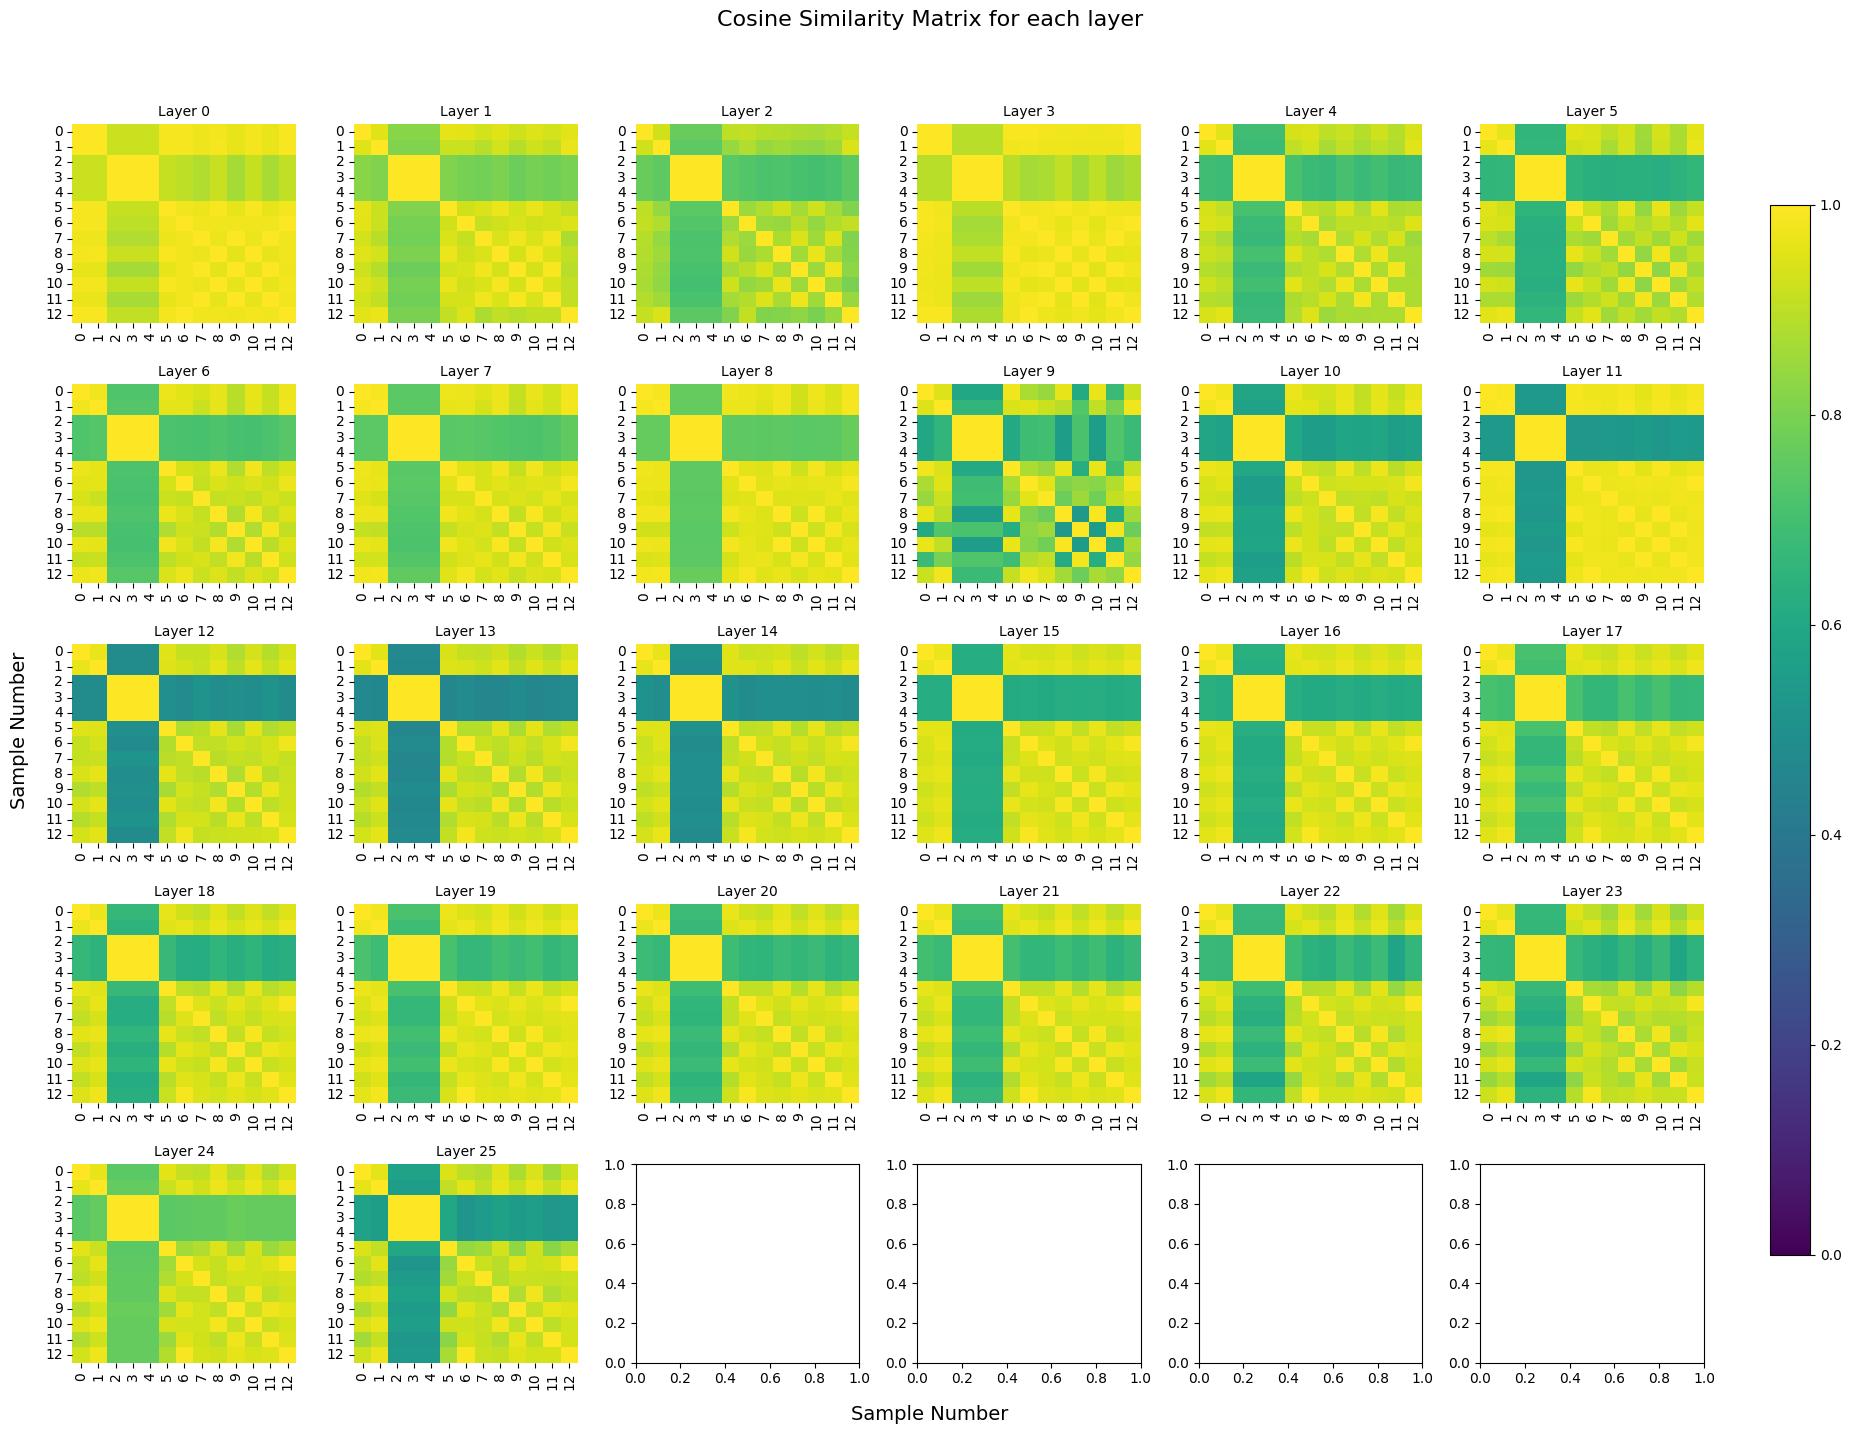

In [114]:
from glob import glob

topics = glob("./topics/*")
for topic in topics[:4]:
    target_topic_tokens = []
    topic_ids = glob(topic + "/**/")
    for topic_id in topic_ids:
        loaded_tensor, loaded_metadata = load_tensor_with_metadata(topic_id + 'tensor')
        target_topic_tokens.append(loaded_tensor[:, list(loaded_metadata['ids'].values()), :])
    tokenized_parts = torch.cat(target_topic_tokens, dim=1)
    latents = []
    for sae_model, part in zip(sae_models, tokenized_parts):
        latents.append(sae_model.encode(part))
    latents = torch.stack(latents)
    cos = F.cosine_similarity(
        latents.unsqueeze(1), latents.unsqueeze(0), 
        dim=-1
    ).detach().cpu()
    cos_new = torch.einsum('vwt -> tvw', cos)
    plot_similarity_by_layer(cos_new, topic_ids)

    cos = F.cosine_similarity(
        latents.unsqueeze(2), latents.unsqueeze(1), 
        dim=-1
    ).detach().cpu()
    plot_similarity_by_sample(cos)
    
    


In [128]:
for topic in topics[:4]:
    for item in data[:100]:
        if item[0][1] == topic.split('/')[-1]:
            for idx in [11, 8, 4, 2, 7, 1, 10, 3]:
                print(item[idx])
            print("#"*40)
            continue

["gross profit's expertise is [MASK].", 'accounting', 'P101(field of work)']
["gross profit's area of work is [MASK].", 'accounting', 'P101(field of work)']
['[MASK] is the expertise of gross profit.', 'accounting', 'P101(field of work)']
['[MASK] is the specialization of gross profit.', 'accounting', 'P101(field of work)']
['[MASK] is the domain of activity of gross profit.', 'accounting', 'P101(field of work)']
['gross profit specializes in [MASK].', 'accounting', 'P101(field of work)']
["gross profit's domain of activity is [MASK].", 'accounting', 'P101(field of work)']
['The expertise of gross profit is [MASK].', 'accounting', 'P101(field of work)']
########################################
["Howard Carter's expertise is [MASK].", 'archaeology', 'P101(field of work)']
["Howard Carter's area of work is [MASK].", 'archaeology', 'P101(field of work)']
['[MASK] is the expertise of Howard Carter.', 'archaeology', 'P101(field of work)']
['[MASK] is the specialization of Howard Carter.', '

In [134]:
from glob import glob

topics = glob("./topics/*")
mean_latents = []
for topic in tqdm(topics):
    target_topic_tokens = []
    topic_ids = glob(topic + "/**/")
    for topic_id in topic_ids:
        loaded_tensor, loaded_metadata = load_tensor_with_metadata(topic_id + 'tensor')
        target_topic_tokens.append(loaded_tensor[:, list(loaded_metadata['ids'].values()), :])
    tokenized_parts = torch.cat(target_topic_tokens, dim=1)
    latents = []
    for sae_model, part in zip(sae_models, tokenized_parts):
        latents.append(sae_model.encode(part))
    mean_latents.append(torch.stack(latents).mean(1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:14<00:00,  2.93it/s]


/tmp/ipykernel_135/3928459842.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])


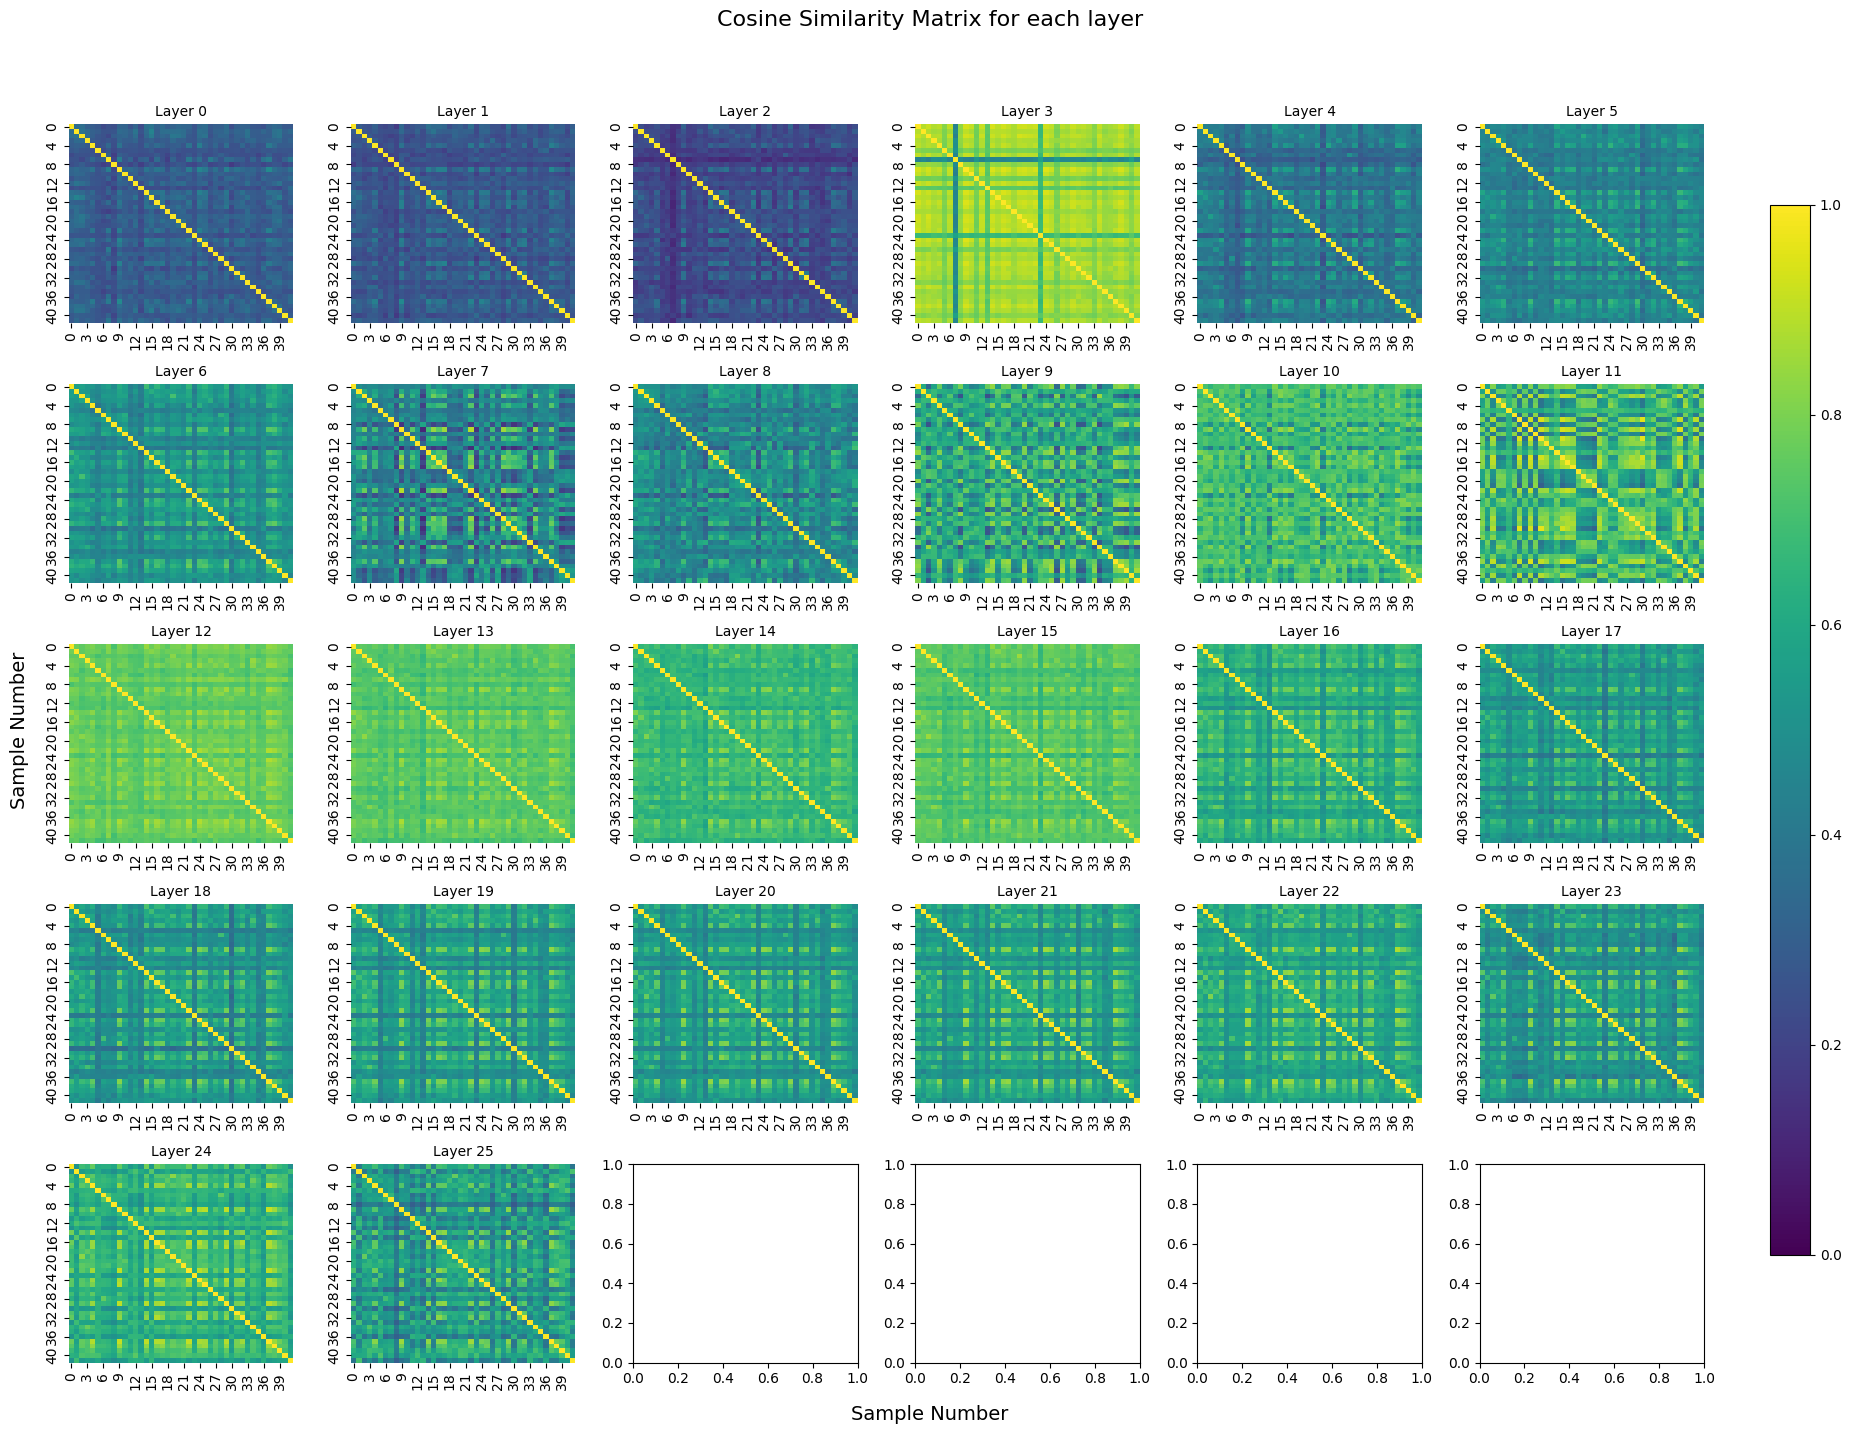

In [149]:
latents = torch.stack(mean_latents)
cos = F.cosine_similarity(
    latents.unsqueeze(1), latents.unsqueeze(0), 
    dim=-1
).detach().cpu()
plot_similarity_by_sample(torch.einsum('Ttl -> lTt',cos))

In [231]:
latents = latents.detach().cpu()
latents.max(1)

torch.return_types.max(
values=tensor([ 26.6970,  18.7447,  12.0189,  40.3261,  49.9850,  36.2379,  30.9105,
         49.3362,  59.5275,  98.1934, 127.5563, 195.0503, 187.5718, 157.7635,
        123.6544, 198.6309, 168.2343, 135.1056, 114.7846, 160.4885, 179.7688,
        212.3351, 246.2340, 202.8778, 250.8284, 228.8770]),
indices=tensor([15745,  7101,  8870,  4730, 12597, 15592,  7589,  5218,  1367, 16122,
         7495, 10153,  9338, 13617,    17,  4594,  9218, 12233,    77, 11447,
        13882, 13966,  4723,    24,   898, 10593]))

In [232]:
for topic, latents, _ in zip(topics, mean_latents, range(5)):
    print("\n"*5, topic.split('/')[-1], "\n"*5)

    top_values, top_indices = torch.topk(latents.max(1).values, k=10)
    top_values, top_indices = top_values.tolist(), top_indices.tolist()

    for value, indice in zip(top_values, top_indices):
        html = get_dashboard_html(
            sae_release = "gemma-2-2b", sae_id=f"{indice}-gemmascope-mlp-16k", 
            feature_idx=latents.max(1).indices[indice]
        )
        display(IFrame(html, width=1200, height=600))
        print(value)






 accounting 







258.85455322265625


243.87176513671875


242.68479919433594


239.07281494140625


203.34906005859375


195.6956024169922


194.89151000976562


190.1871337890625


186.781494140625


173.296875





 archaeology 







326.91009521484375


254.27679443359375


230.85960388183594


212.80398559570312


212.66539001464844


207.15060424804688


202.76641845703125


181.3799285888672


180.8102569580078


170.8924560546875





 ballet 







274.972900390625


245.06521606445312


241.64974975585938


235.3089599609375


209.3946533203125


207.69400024414062


207.3833770751953


203.19485473632812


193.36614990234375


185.071533203125





 bird 







354.34808349609375


277.2149963378906


269.09576416015625


265.54217529296875


224.5869903564453


206.21510314941406


198.6396484375


197.0879669189453


195.32420349121094


195.0105438232422





 science 







250.82839965820312


246.23403930664062


228.8770294189453


212.33511352539062


202.87783813476562


198.6309051513672


195.05029296875


187.5718231201172


179.768798828125


168.2342529296875
